# Libraries

In [168]:
import pandas as pd
import numpy as np
import os
import matplotlib.font_manager as fm
import time

# Plotting Libs
import matplotlib.pyplot as plt 
from sklearn.tree import plot_tree
from xgboost import plot_importance
import shap

# Statistical Libs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.feature_selection import SelectFromModel

# Collinearity / Feature Selection Libs 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# Model Libs
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier

# Accuracy Libs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

# Resampling Libs
from imblearn.under_sampling import RandomUnderSampler



# Load Data

In [169]:
start_time = time.time()

In [170]:
df1 = pd.read_pickle(r".\df_dummies\df1_dummies.pkl")
df2 = pd.read_pickle(r".\df_dummies\df2_dummies.pkl")
df3 = pd.read_pickle(r".\df_dummies\df3_dummies.pkl")
df4 = pd.read_pickle(r".\df_dummies\df4_dummies.pkl")


# Accuracy tests/ Roc Function


In [171]:
def accuracy(dfi, i, model, X_test, y_test, y_pred, title):
    print(f"Model : Phase {i} - {title}")
    
    print("\na).\nAccuracy Score : (True P + True N) / N total :")
    print(f"{accuracy_score(y_test, y_pred) * 100:.2f}%")

    print("\nb).\nClassification Report :")
    print(classification_report(y_test, y_pred))

    print("\nc).\nMatthews Correlation Coefficient (MCC) :")
    print(matthews_corrcoef(y_test, y_pred))

    print("\nd).\nPlots :")
    fig , ax = plt.subplots(figsize = (20, 6), nrows = 1, ncols = 3)
    ConfusionMatrixDisplay.from_predictions(y_test , y_pred, ax = ax[0]);
    RocCurveDisplay.from_estimator(model, X_test, y_test, pos_label = 1, ax = ax[1], name = f'{title}');  # Completed = 0, Terminated = 1
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, pos_label=1, ax=ax[2], name=f'{title}')
    print(f"ROC AUC : {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]).round(2)}") # Predict Probabilities for accurate ROC Auc")
    print(f"PR AUC : {average_precision_score(y_test, model.predict_proba(X_test)[:, 1]).round(2)}")

    plt.suptitle(f"Phase {i} - {title}", fontsize = 11, fontweight = 'bold')

    # Confusion Matrix
    ax[0].set_title("1. Confusion Matrix", fontsize = 10, fontweight = 'bold')
    ax[0].set_xlabel("Predicted Label", fontsize = 10, fontweight = 'bold')
    ax[0].set_ylabel("True Label", fontsize = 10, fontweight = 'bold')
    
    # Roc Curve
    ax[1].set_title("2. ROC Curve" , fontsize = 10, fontweight = 'bold')
    ax[1].set_ylabel("TPR - Sensitivity - Recall", fontsize = 10, fontweight = 'bold')
    ax[1].set_xlabel("FPR - (1 - Specificity)", fontsize = 10, fontweight = 'bold')

    # PR Cruve
    ax[2].set_title("3. PR Curve", fontsize=10, fontweight='bold')
    ax[2].set_ylabel("PPV - Precision", fontsize=10, fontweight='bold')
    ax[2].set_xlabel("TPR - Sensitivity - Recall", fontsize=10, fontweight='bold')

    plt.show()      
    plt.close(fig)  

# Data Preparation

## Df Input

In [172]:
display(df1.shape)
display(df2.shape)
display(df3.shape)
display(df4.shape)


(27324, 103)

(29260, 103)

(16503, 103)

(13246, 104)

In [173]:
i = 3
dfi = df3

## Drop

In [174]:
cols = [col for col in dfi.columns if 'Adverse_System_List_' in col or 'Masking_Detail' in col or \
        'Adverse_System_Counts_Log' in col]
dfi = dfi.drop(cols, axis = 1)

## X , y

In [175]:
X = dfi.drop("Study_Status_Bin", axis = 1)
y = dfi["Study_Status_Bin"]

# initial X features
X.shape # Check that initial shape of dfi was not changed.

(16503, 75)

## Train - Test Split

In [176]:
# Train-Test Split
if i == 2:
    X_train_tts, X_test_tts, y_train_tts, y_test_tss = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
else:
    X_train_tts, X_test_tts, y_train_tts, y_test_tss = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

y_train_tts.value_counts().iloc[1]/y_train_tts.value_counts().iloc[0] # Imbalanced 0 row = Compeleted, row 1 = terminated

0.21744743637034306

## Resample
- Datasets are imbalanced towards the positive class. (i.e. COMPLETED = 1)
- Resample train set only, so model will be correctly trained (not biased towards the most common category of Study_Status).
    --> Avoids information leaking to test set. test set always similar to true cases.
- Performance evaluated on unsampled test set, with real data percentages per category.

In [177]:
res = RandomUnderSampler(sampling_strategy = 'auto', random_state = 42)
X_train_res, y_train_res = res.fit_resample(X_train_tts, y_train_tts) 

# Final train/test ratio
display(f'X_test/X_train : {X_test_tts.shape[0]}/{X_train_res.shape[0]} = {(X_test_tts.shape[0]/X_train_res.shape[0])}')
display(X_train_res.shape[1], X_train_res.shape[1]/X_train_res.shape[0])

'X_test/X_train : 3301/4716 = 0.6999575911789653'

75

0.015903307888040712

## Scaling
- Scale after resample, similarly to train_test_Split so it wont take the skewed distribution of imbalanced data.

In [178]:
def fun_scale(X_train_sc_par, X_test_sc_par):  # Scaling always after dataset split

    X_train_sc = X_train_sc_par.copy()
    X_test_sc = X_test_sc_par.copy()

    cont_cols = [col for col in X_train_sc.columns 
                    if (('count' in col.lower() or 'log' in col.lower()) and
                        not any(x in col.lower() for x in ['bin', 'categ', 'list']))]
    if cont_cols:
        scaler = StandardScaler(with_mean = True, with_std = True)

        X_train_sc[cont_cols] = pd.DataFrame(scaler.fit_transform(X_train_sc[cont_cols]),
            columns = cont_cols, index=X_train_sc.index)

        X_test_sc[cont_cols] = pd.DataFrame(scaler.transform(X_test_sc[cont_cols]),
            columns = cont_cols, index=X_test_sc.index)
    else:
        print("No continuous/log columns to scale.")

    return X_train_sc, X_test_sc

X_train_sc, X_test_sc = fun_scale(X_train_res, X_test_tts)

# check if any continues values had negative values
col = [col for col in dfi.columns if '_Log' in col or '_Counts' in col]
dfi[col].describe()

Completion_Gap_Log  Adverse_Counts_Log  Arm_Counts_Log  \
count             16503.0        16503.000000    16503.000000   
mean             3.132599            2.082360        1.142872   
std              0.829771            2.582580        0.265376   
min                   0.0            0.000000        0.693147   
25%              2.639057            0.000000        1.098612   
50%              3.218876            0.000000        1.098612   
75%              3.713572            4.543295        1.098612   
max               5.09375           10.777100        3.496508   

       City_Counts_Log  Enrollment_Counts_Log  
count     16503.000000           16503.000000  
mean          1.992742               4.848329  
std           1.587324               1.804146  
min           0.000000               0.000000  
25%           0.693147               3.951244  
50%           1.098612               5.068904  
75%           3.367296               6.035481  
max           6.970730              12.228025

## Rename

In [179]:
def fun_rename(X_train, X_test, y_train, y_test):

    X_train.columns = X_train.columns.str.replace(r'List_|Detail_|Adv_Syst_|Adv_', "", regex=True)
    X_train.columns = X_train.columns.str.replace(r'Counts_Log', "Log", regex=True)
    X_train.columns = X_train.columns.str.replace(r'Funder_Type', "Funder", regex=True)
    X_train.columns = X_train.columns.str.replace(r'_', " ", regex=True)

    X_test.columns = X_test.columns.str.replace(r'List_|Detail_|Adv_Syst_|Adv_', "", regex=True)
    X_test.columns = X_test.columns.str.replace(r'Counts_Log', "Log", regex=True)
    X_test.columns = X_test.columns.str.replace(r'Funder_Type', "Funder", regex=True)
    X_test.columns = X_test.columns.str.replace(r'_', " ", regex=True)

    y_train.name = y_train.name.replace('Study_Status_Bin', 'Study Status')
    y_test.name = y_test.name.replace('Study_Status_Bin', 'Study Status')

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = fun_rename(X_train_sc, X_test_sc, y_train_res, y_test_tss)

# X_train.columns.to_list()

## MI 
- Info overlap (nonlinear)
- Mutual information (MI) 1 between two random variables is a non-negative value, which measures the dependency between the variables.

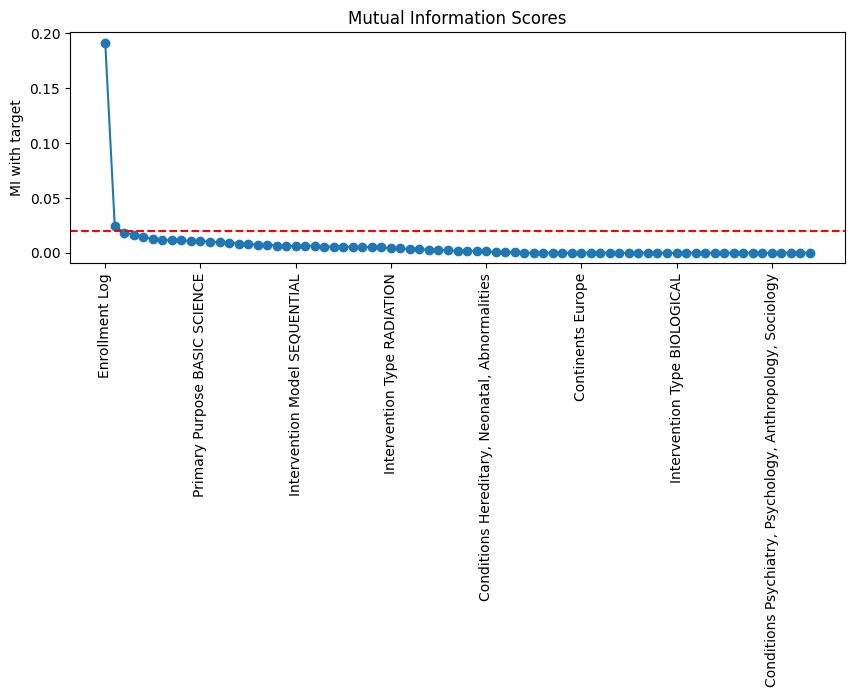

44

In [180]:
mi_scores = mutual_info_classif(X_train, y_train, random_state = 42)
mi = pd.Series(mi_scores, index = X_train.columns)
kept_cols = mi[mi > 0].index # If threshold is too strict and drops everything, keep the best one to avoid empty matrix

if len(kept_cols) == 0: 
    kept_cols = [mi.idxmax()] 

X_train_mi = X_train.loc[:, kept_cols].copy() 
X_test_mi = X_test.loc[:, kept_cols].copy()
    
mi_series = pd.Series(mi_scores, index = X_train.columns).sort_values(ascending=False)

plt.figure(figsize = (10, 3))
mi_series.plot(marker = 'o')
plt.axhline(0.02, color = 'red', linestyle = '--')  # example threshold
plt.title("Mutual Information Scores")
plt.ylabel("MI with target")
plt.xticks(rotation = 90)
plt.show()

display(X_train_mi.shape[1])

# Models

## A) Classic Classification

### Logistic (L1)

Model : Phase 3 - Lasso Logistic Regression (L1)

a).
Accuracy Score : (True P + True N) / N total :
78.85%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      2712
           1       0.44      0.70      0.54       589

    accuracy                           0.79      3301
   macro avg       0.68      0.75      0.70      3301
weighted avg       0.84      0.79      0.81      3301


c).
Matthews Correlation Coefficient (MCC) :
0.4297251049334982

d).
Plots :
ROC AUC : 0.84
PR AUC : 0.69


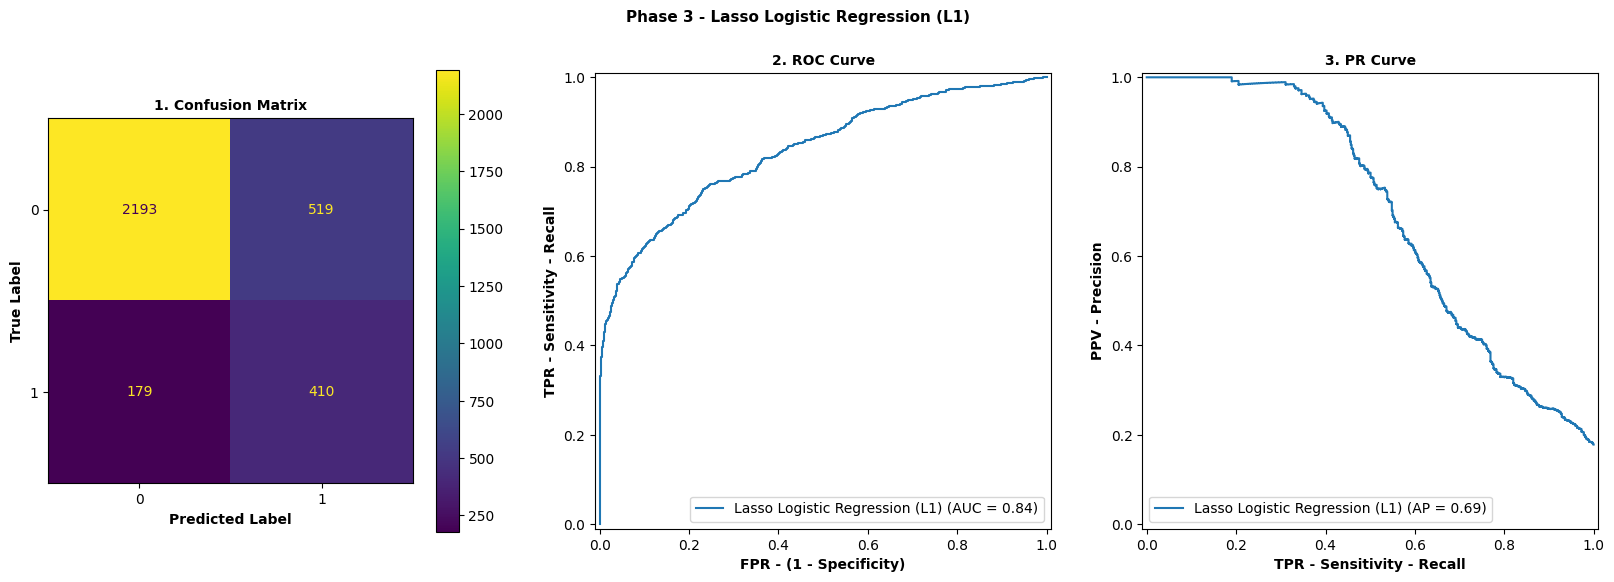

In [181]:
# Model
log_reg = LogisticRegression(penalty = 'l1', max_iter = 5000 , solver = 'saga', class_weight = 'balanced',  random_state = 42)  

# Final Model
log_model = log_reg.fit(X_train, y_train)

# y_pred
y_pred_log_l1 = log_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, log_model, X_test, y_test, y_pred_log_l1, "Lasso Logistic Regression (L1)")


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_14040\858464433.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)


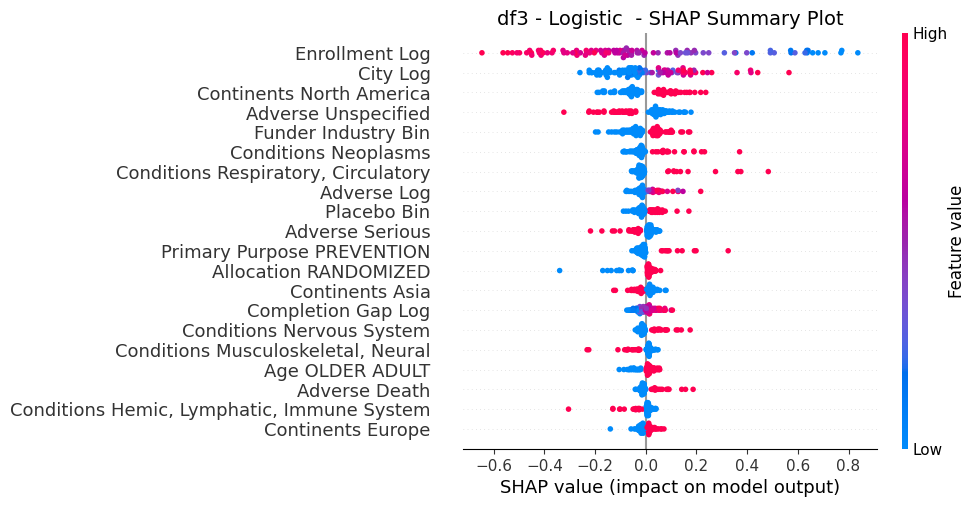

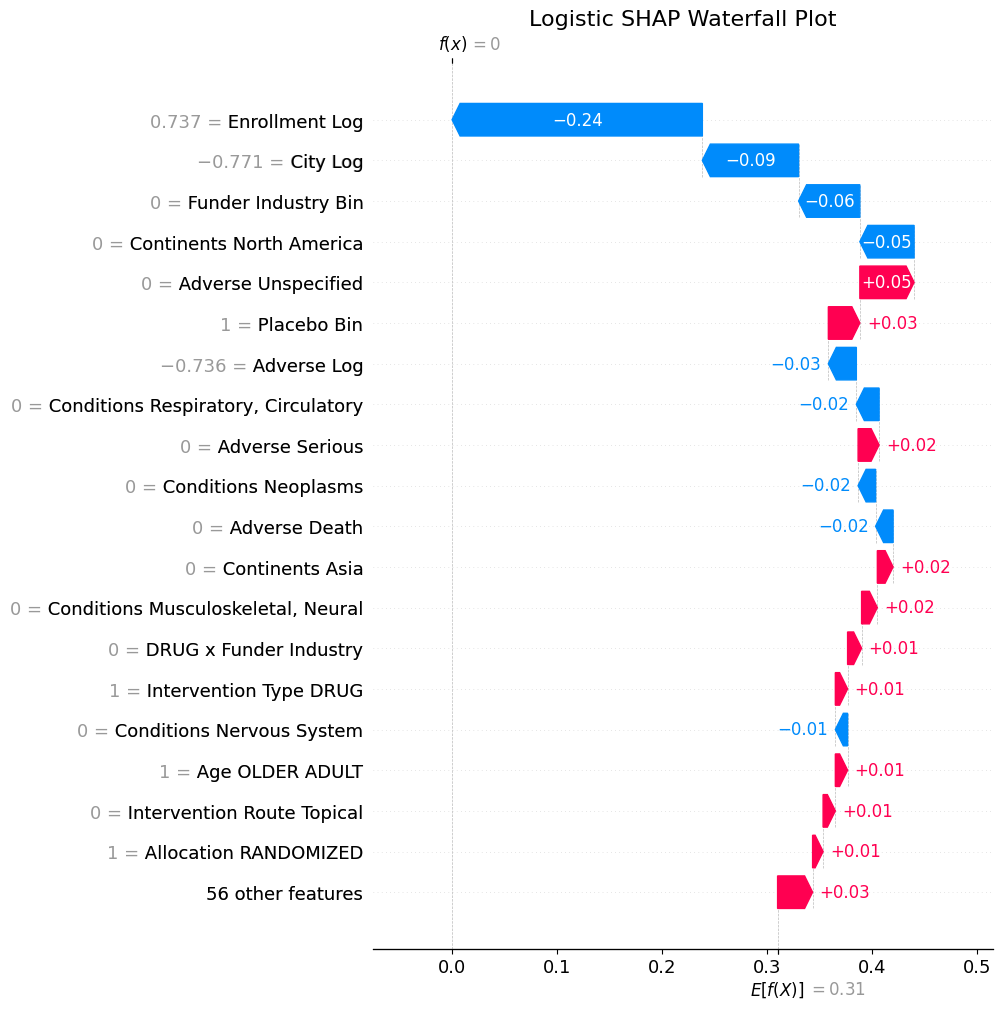

In [182]:
# SHAP Summary PLot:
# Impact on the prediction (how much a feature contributes to pushing the prediction left (negative) or right (positive)).
# Blue = low feature value.
# Red = high feature value.

# Example: Enrollment_Counts_Log:
# High values (red) → strong negative SHAP values → push prediction to Completed.
# Low values (blue) → positive SHAP values → push toward Terminated.
# SHAP X-axis shows how much each feature pushes the prediction toward class 0 or 1, in log-odds space. (value -5)

# SHAP dataset overview
X_test_sam = shap.sample(X_test, 100)
explainer = shap.Explainer(log_model.predict, X_test_sam)
shap_values = explainer(X_test_sam)

# Summary Plot --> overall 
model = 'log_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Logistic  - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Waterfall Plot --> 1 data point prediction
shap.waterfall_plot(shap_values[0], max_display = 20, show = False) 
plt.title("Logistic SHAP Waterfall Plot", fontsize = 16) 

# Show Plot
plt.show()


### LDA - Linear Discriminant Analysis

- QDA and LDA assume Gaussian distributions.

Best Parameters : {'n_components': 1, 'shrinkage': 0.334}
Best Estimator : LinearDiscriminantAnalysis(n_components=1, shrinkage=0.334, solver='lsqr',
                           store_covariance=True)
Model : Phase 3 - Linear Discriminant Analysis (LDA)

a).
Accuracy Score : (True P + True N) / N total :
80.82%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      2712
           1       0.47      0.67      0.55       589

    accuracy                           0.81      3301
   macro avg       0.70      0.75      0.72      3301
weighted avg       0.84      0.81      0.82      3301


c).
Matthews Correlation Coefficient (MCC) :
0.4466432263617388

d).
Plots :
ROC AUC : 0.83
PR AUC : 0.69


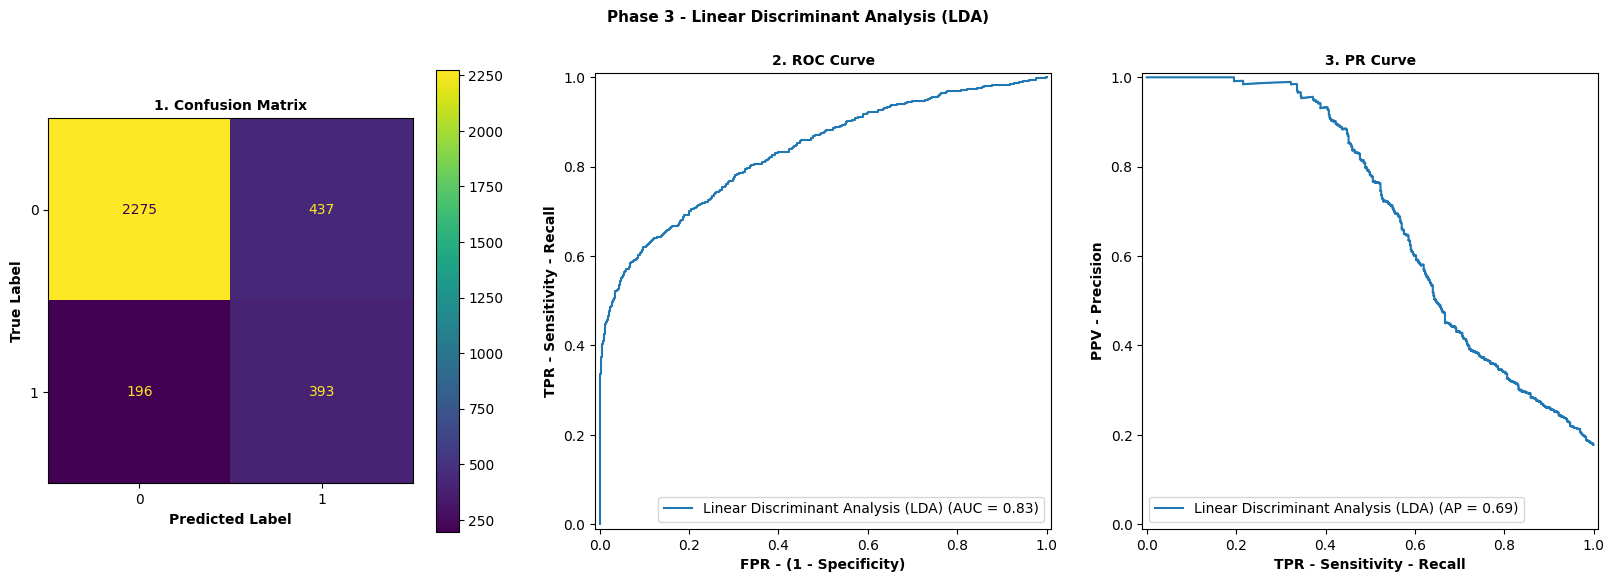

In [183]:
# Model
lda = LDA(store_covariance = True, solver = 'lsqr') # Use solver = lsqr if cv needed.

# Grid Search CV
param_grid = {
    "shrinkage" : [None, "auto"] + list(np.linspace(0.001, 1.0, 10)), # sklearn doc: float between 0 and 1
    'n_components' : np.arange(1, min(X_train.shape[1], len(np.unique(y_train)) - 1) + 1)
    } 
lda_grid = GridSearchCV(lda, param_grid = param_grid, cv = 5, n_jobs = -1) 

# Final Model
lda_model = lda_grid.fit(X_train, y_train) # automatically gives the best.estimator
print(f'Best Parameters : {lda_model.best_params_}')
print(f'Best Estimator : {lda_model.best_estimator_}')

# y_pred
y_pred_lda = lda_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, lda_model, X_test, y_test, y_pred_lda, "Linear Discriminant Analysis (LDA)")


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_14040\1076448959.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)


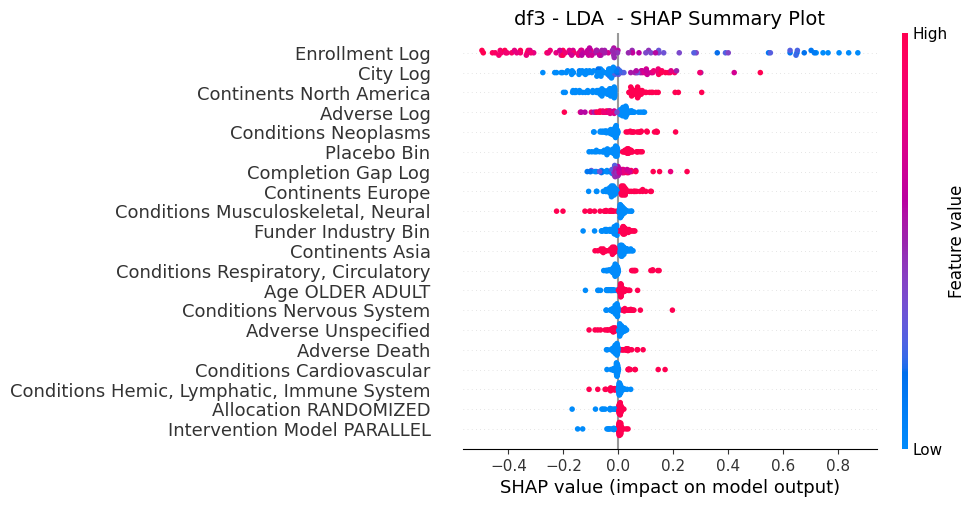

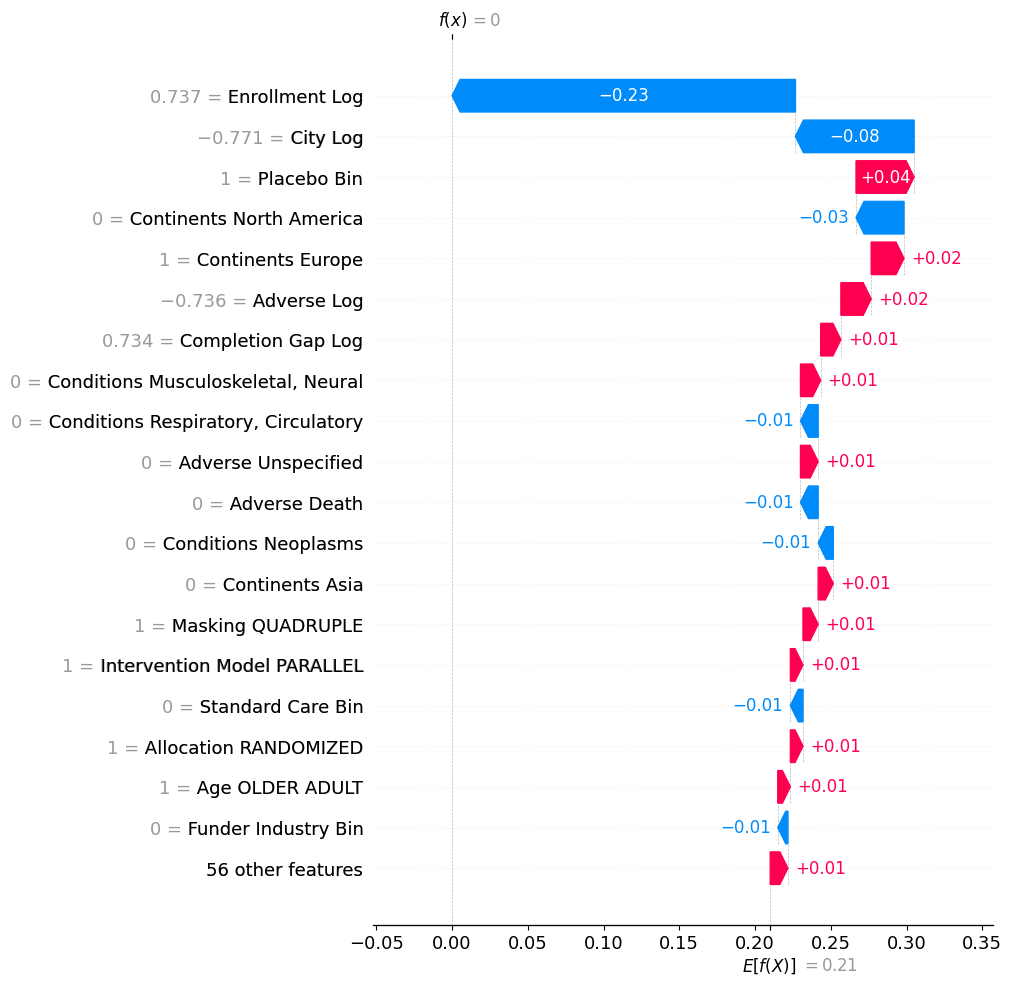

In [184]:
# SHAP
X_test_sam = shap.sample(X_test, 100)
explainer = shap.Explainer(lda_model.best_estimator_.predict, X_test_sam)
shap_values = explainer(X_test_sam)

# Save plot
model = 'lda_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - LDA  - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)


### QDA - Quantratic Discriminant Analysis
- QDA very sensistive to collinear data!
QDA and LDA assume Gaussian distributions.

"Best Parameters : {'reg_param': 0.20689655172413793}"

'Best Estimator : QuadraticDiscriminantAnalysis(reg_param=0.20689655172413793,\n                              store_covariance=True)'

Model : Phase 3 - Quantric Discriminant Analysis (QDA)

a).
Accuracy Score : (True P + True N) / N total :
79.85%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      2712
           1       0.46      0.71      0.56       589

    accuracy                           0.80      3301
   macro avg       0.69      0.77      0.71      3301
weighted avg       0.85      0.80      0.81      3301


c).
Matthews Correlation Coefficient (MCC) :
0.45335213271147207

d).
Plots :
ROC AUC : 0.84
PR AUC : 0.7


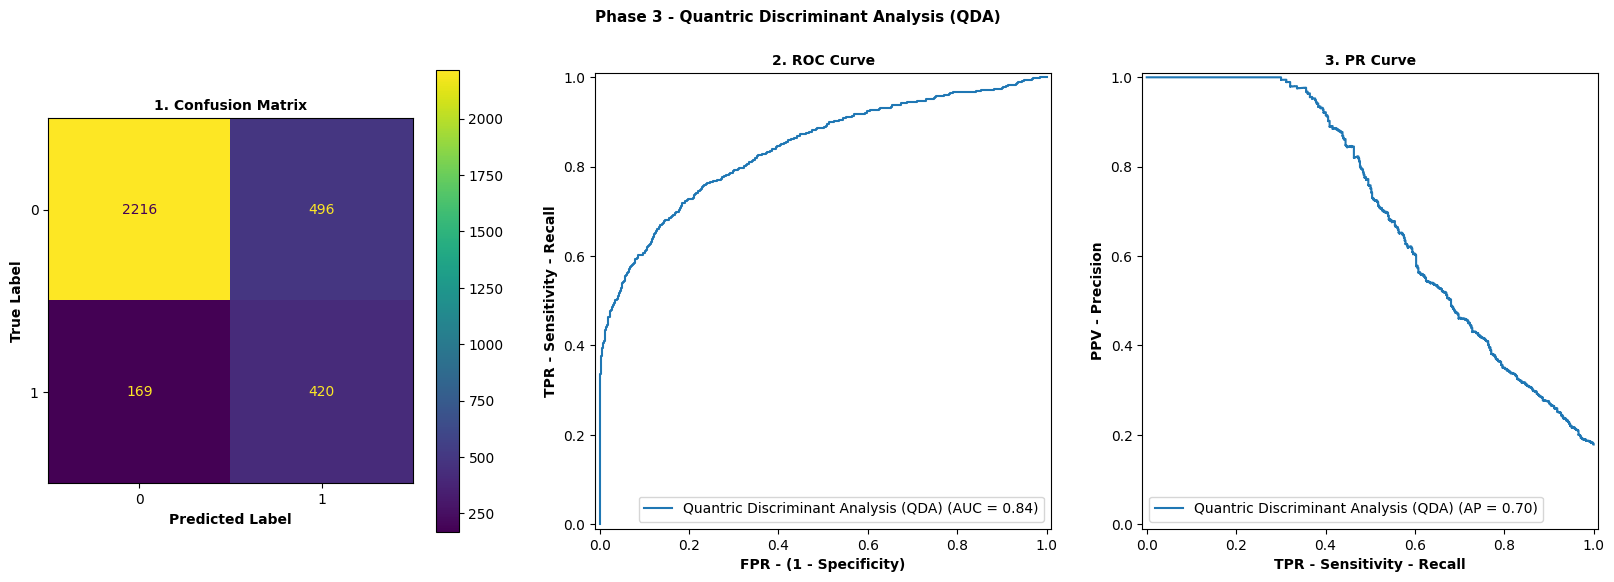

In [185]:
# Model
# QDA does not assume linear relation X - y --> lasso assumes. 
qda = QDA(store_covariance = True)

# GridSearch
param_grid = {
    "reg_param": np.linspace(0, 1, 30) # value range [0,1]
    }
qda_grid = GridSearchCV(qda, param_grid = param_grid, cv = 5, n_jobs = 3) # cv = 5 default # n_jobs = -1 avoid overload

# Final model
qda_model = qda_grid.fit(X_train, y_train)
display(f'Best Parameters : {qda_model.best_params_}')
display(f'Best Estimator : {qda_model.best_estimator_}')

# y_pred
y_pred_qda = qda_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, qda_model, X_test, y_test, y_pred_qda, "Quantric Discriminant Analysis (QDA)")

C:\Users\Eugenia\AppData\Local\Temp\ipykernel_14040\3695208589.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)


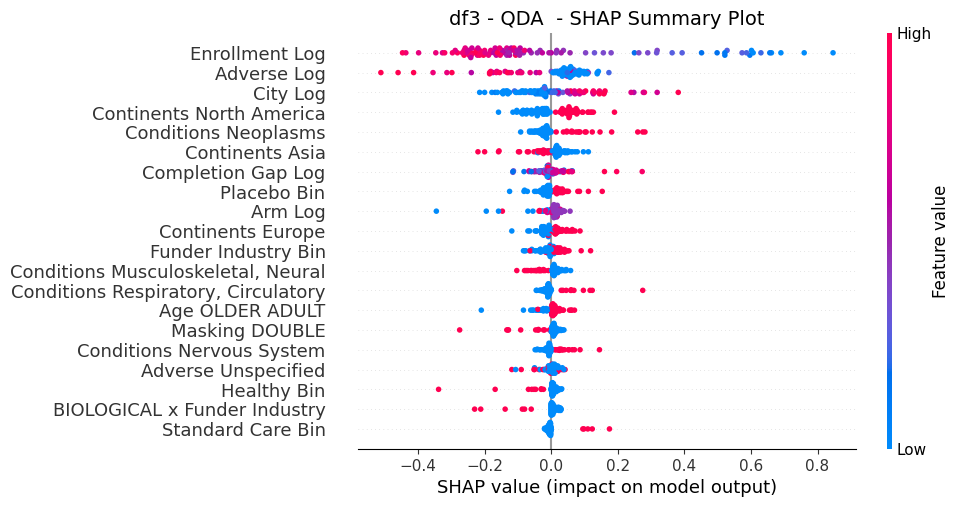

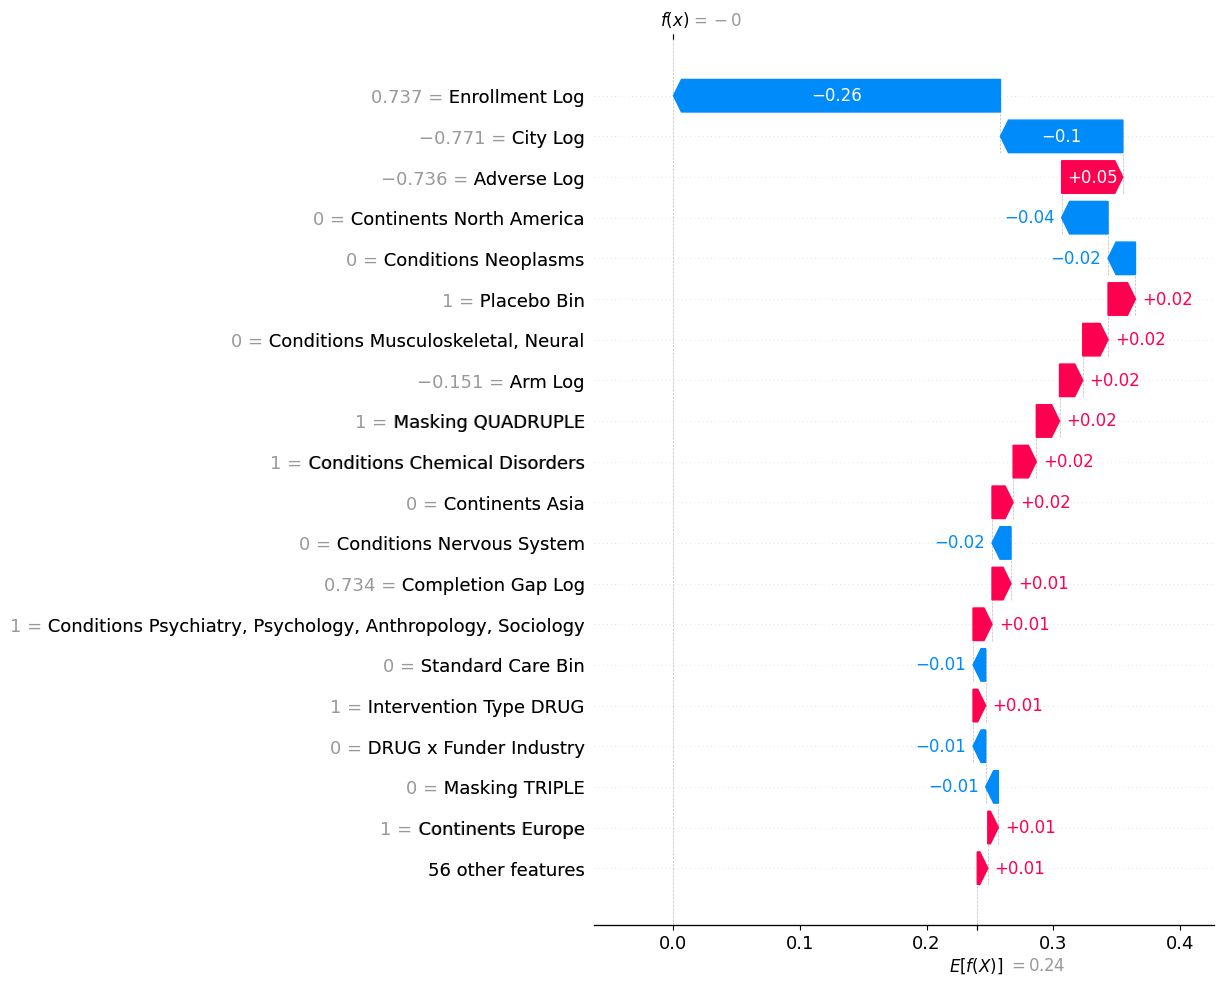

In [186]:
# SHAP
X_test_sam = shap.sample(X_test, 100)
explainer = shap.Explainer(qda_model.best_estimator_.predict, X_test_sam)
shap_values = explainer(X_test_sam)

# Save plot
model = 'qda_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - QDA  - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### Elastic Net Logistic Regression
- l1_ratio l1 / l2 = Elastic Net
- l1_ratio = 1 = Lasso (l1)
- l1_ratio = 0 = Ridge (l2) 
- 0 < l1_ratio < 1 

"Best Parameters : {'l1_ratio': 0.30000000000000004}"

"Best Estimator : LogisticRegression(l1_ratio=0.30000000000000004, max_iter=3000,\n                   penalty='elasticnet', random_state=42, solver='saga')"

Model : Phase 3 - Elastic Net Logistic Regression

a).
Accuracy Score : (True P + True N) / N total :
78.79%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      2712
           1       0.44      0.70      0.54       589

    accuracy                           0.79      3301
   macro avg       0.68      0.75      0.70      3301
weighted avg       0.84      0.79      0.80      3301


c).
Matthews Correlation Coefficient (MCC) :
0.42966799318860993

d).
Plots :
ROC AUC : 0.84
PR AUC : 0.69


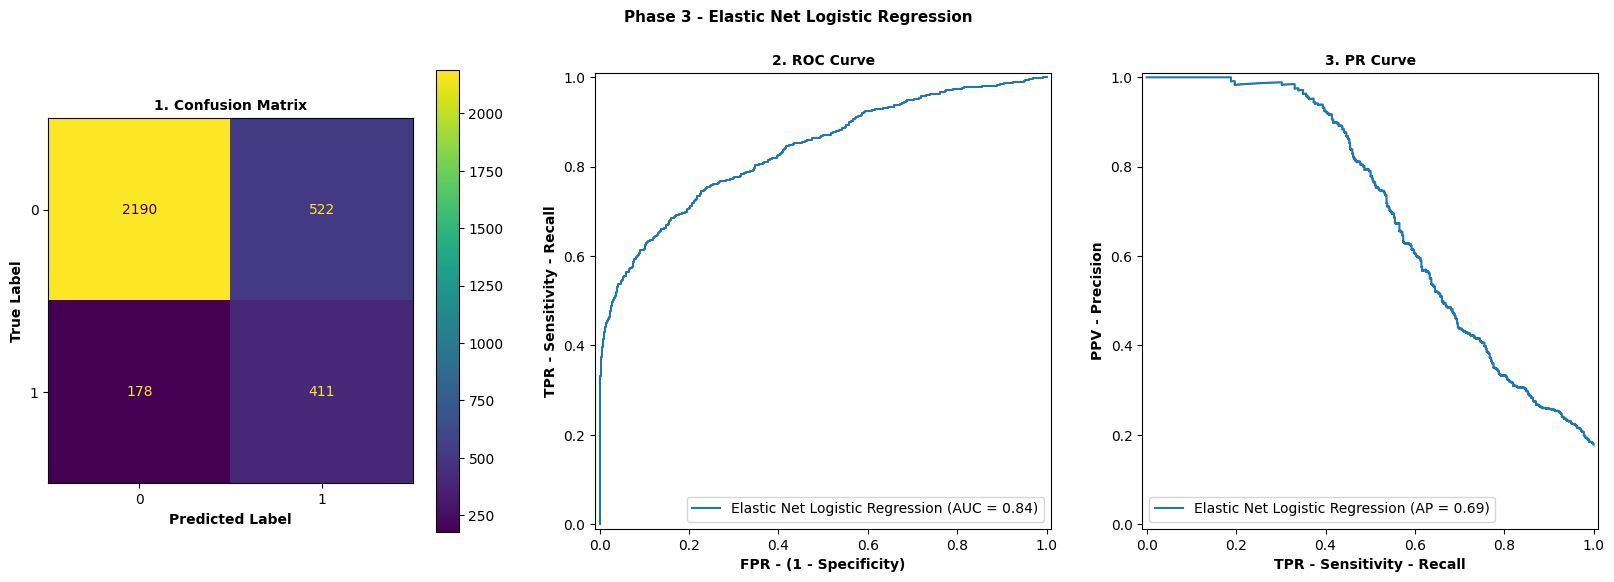

In [187]:
# Model (4+min df5)
log_el = LogisticRegression(penalty = 'elasticnet', max_iter = 3000, solver = "saga", random_state = 42)   

# Grid Search
param_grid = {
    "l1_ratio" : np.linspace(0.1, 1, 10, endpoint = True)
    } 
log_el_grid = GridSearchCV(log_el, param_grid = param_grid, cv = 5, n_jobs = 3)

# Final Model
el_model = log_el_grid.fit(X_train, y_train)  
display(f'Best Parameters : {el_model.best_params_}')
display(f'Best Estimator : {el_model.best_estimator_}')

# y_pred
y_pred_el = el_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, el_model, X_test, y_test, y_pred_el, "Elastic Net Logistic Regression")


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_14040\4250722229.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)


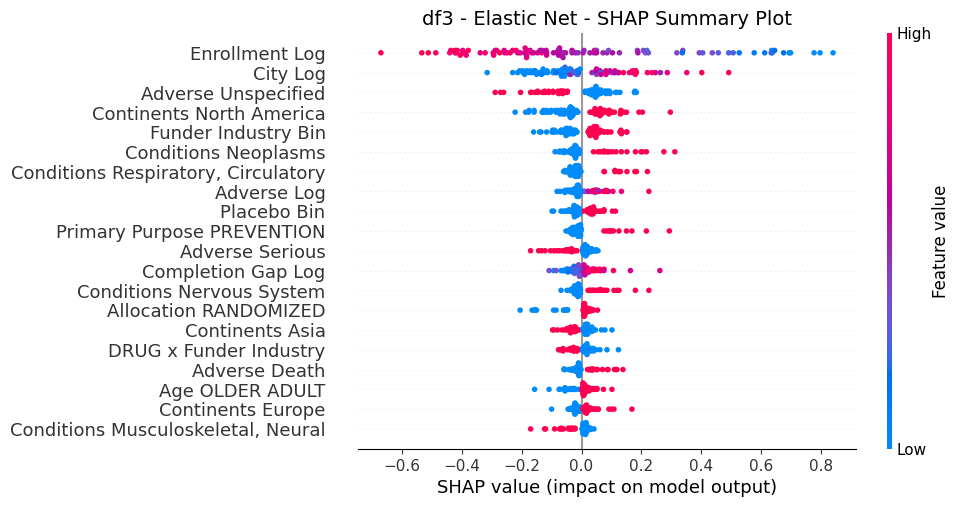

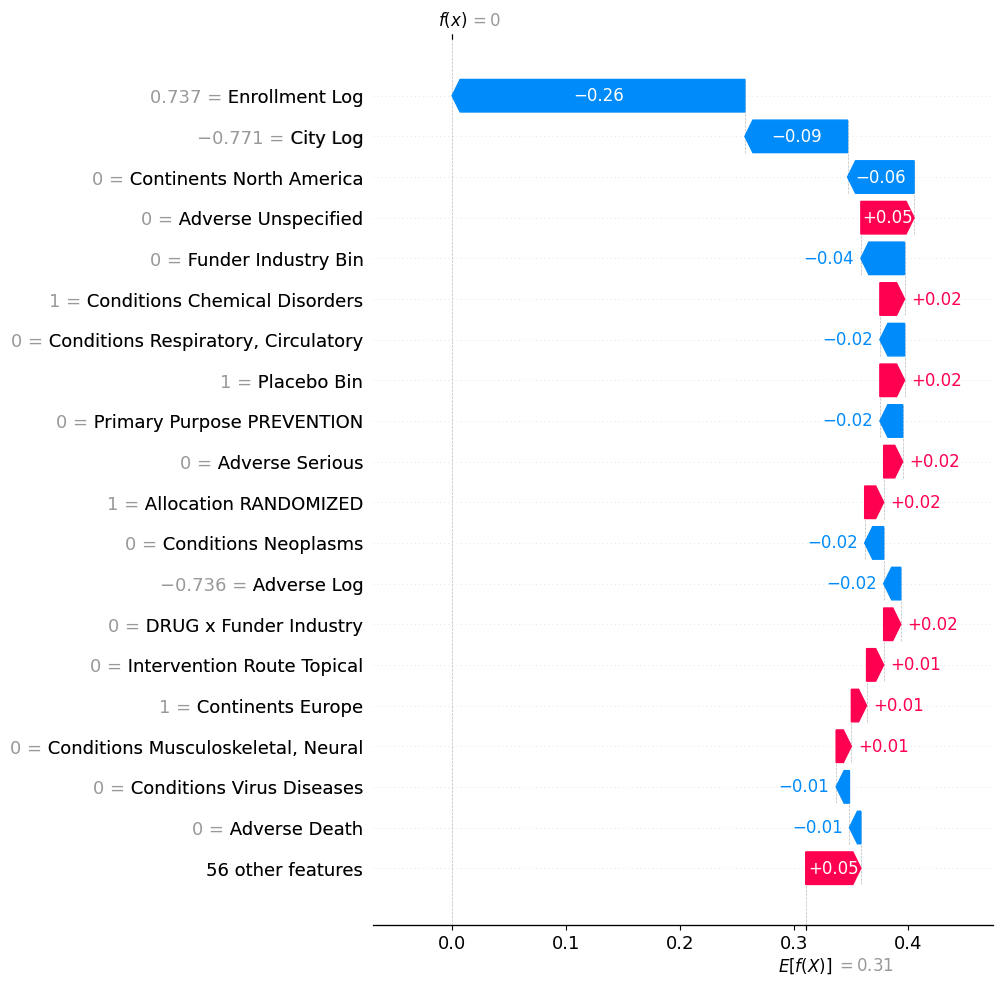

In [188]:
# SHAP
X_test_sam = shap.sample(X_test, 100)
explainer = shap.Explainer(el_model.best_estimator_.predict, X_test_sam)
shap_values = explainer(X_test_sam)

# Save plot
model = 'el_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Elastic Net - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

## B) ML Classification

### KNN - K Nearest Neighbors

"Best Parameters : {'n_neighbors': 53}"

'Best Estimator : KNeighborsClassifier(n_neighbors=53)'

Model : Phase 3 - K-Nearest Neighbors Classifier (KNN)

a).
Accuracy Score : (True P + True N) / N total :
81.40%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      2712
           1       0.48      0.65      0.56       589

    accuracy                           0.81      3301
   macro avg       0.70      0.75      0.72      3301
weighted avg       0.84      0.81      0.82      3301


c).
Matthews Correlation Coefficient (MCC) :
0.4491198851304506

d).
Plots :
ROC AUC : 0.82
PR AUC : 0.66


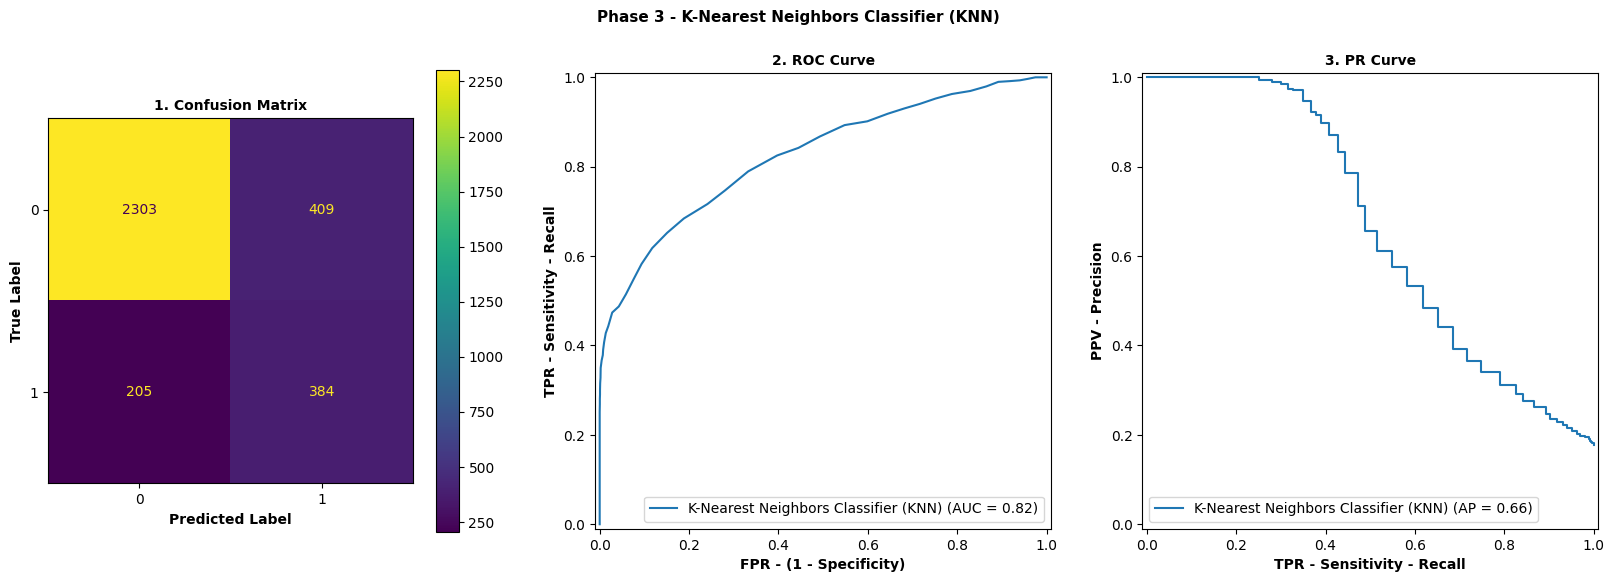

In [189]:
# Model 
knn = KNeighborsClassifier()

# Grid Search
param_grid = {"n_neighbors" : np.linspace(1, 100, 50, endpoint = True).astype(int)} 

# CV
knn_grid = GridSearchCV(knn , param_grid = param_grid, cv = 5, n_jobs = 3)

# Final Model
knn_model = knn_grid.fit(X_train, y_train)
display(f'Best Parameters : {knn_model.best_params_}')
display(f'Best Estimator : {knn_model.best_estimator_}')

# y_pred
y_pred_knn = knn_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, knn_model, X_test, y_test, y_pred_knn, "K-Nearest Neighbors Classifier (KNN)")


PermutationExplainer explainer: 101it [01:35,  1.07s/it]                         
C:\Users\Eugenia\AppData\Local\Temp\ipykernel_14040\3907595860.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)


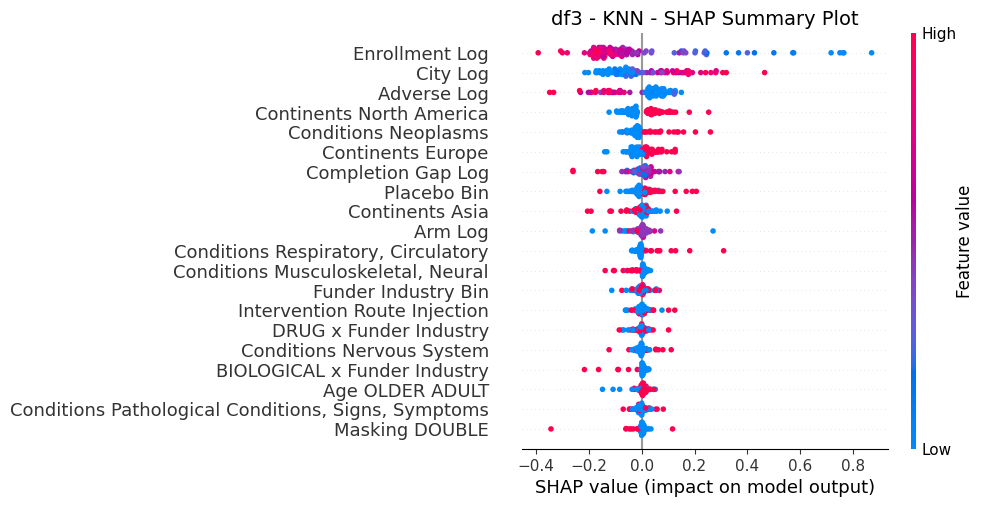

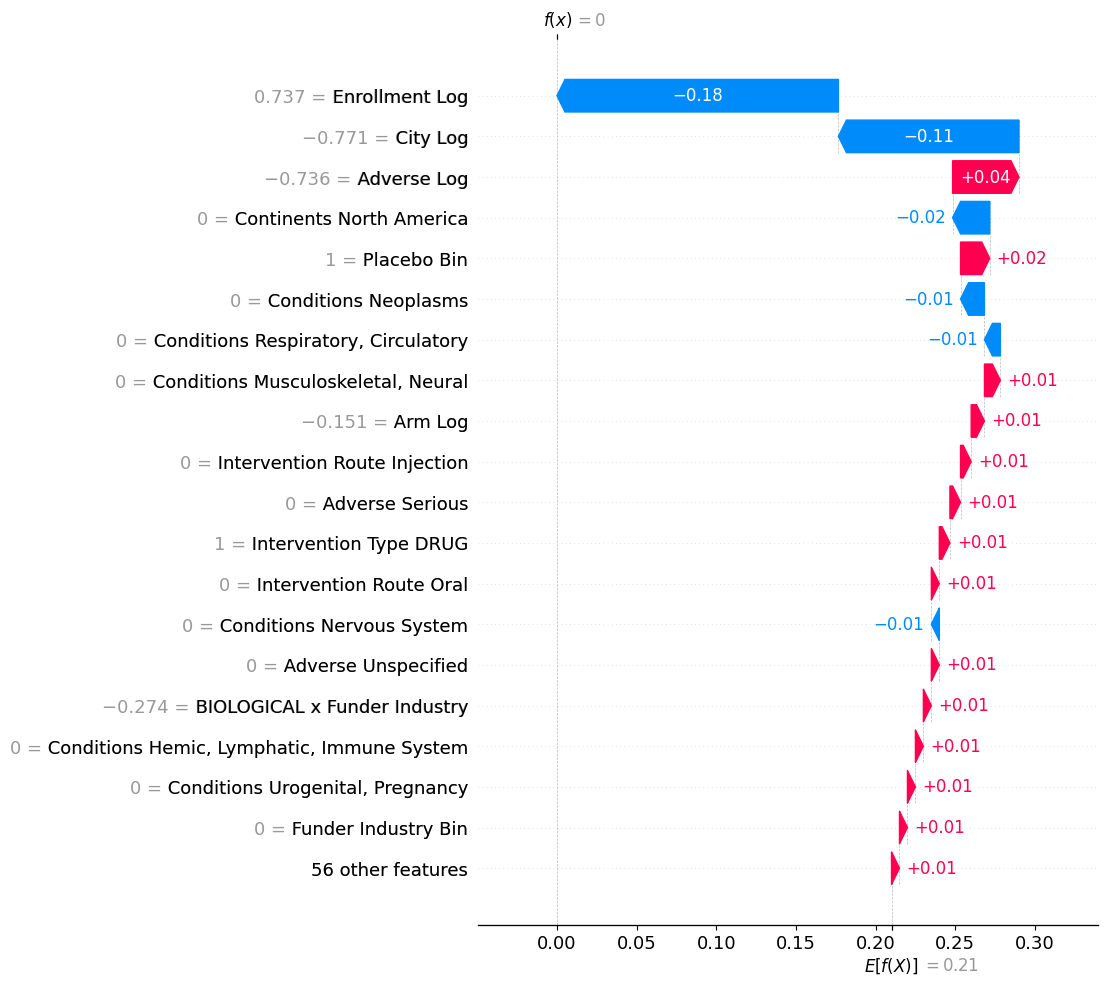

In [190]:
# SHAP
X_test_sam = shap.sample(X_test, 100)  # sample needed for computational efficacy
explainer = shap.Explainer(knn_model.best_estimator_.predict, X_test_sam)
shap_values = explainer(X_test_sam)

# Save plot
model = 'knn_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - KNN - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### SVC - Support Vector Classifier
- Always Chooses rbf
- poly is not going to be checked as it extremely increases compuational time, wihtout never be chosen. 
- rbf can find some non-linear boundries close to poly if needed. 


In [ ]:
# Model (20 mins)
svc = SVC(probability = True, random_state = 42, class_weight = 'balanced')

# Hyperparameters CV
# For computetional efficacy, hyperparameters' values were checked arund the chosen value, which was for all phases.
param_grid = [
    # {"kernel": ["linear"], "C": [0.4, 0.5, 0.6, 0.7, 1]},  # linear was never chosen. Excluded for comp. efficacy
    {"kernel": ["rbf"], "C": [0.4, 0.5, 0.6, 0.7, 1]},   # rbf always chosen from all models
    # {"kernel": ["sigmoid"], "C": [0.4, 0.5, 0.6, 0.7, 1]}, # sigmid was never chosen. excluded for comp. efficacy
    # {"kernel": ["poly"], "C": [0.1, 1], "degree": [2]}, # poly: Never chosen. Increases comp. time if in grid.
]

# CV
svc_grid = GridSearchCV(svc, param_grid = param_grid, cv = 5, n_jobs = -1) 

# Final Model
svc_model = svc_grid.fit(X_train, y_train)
display(f'Best Parameter: {svc_model.best_params_}')
display(f'Best Estimator: {svc_model.best_estimator_}')

# y_pred
y_pred_svc = svc_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, svc_model, X_test, y_test, y_pred_svc, "Support Vector Classifier (SVC)")


PermutationExplainer explainer: 31it [00:32,  1.55s/it]                        
C:\Users\Eugenia\AppData\Local\Temp\ipykernel_14040\2777636897.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)


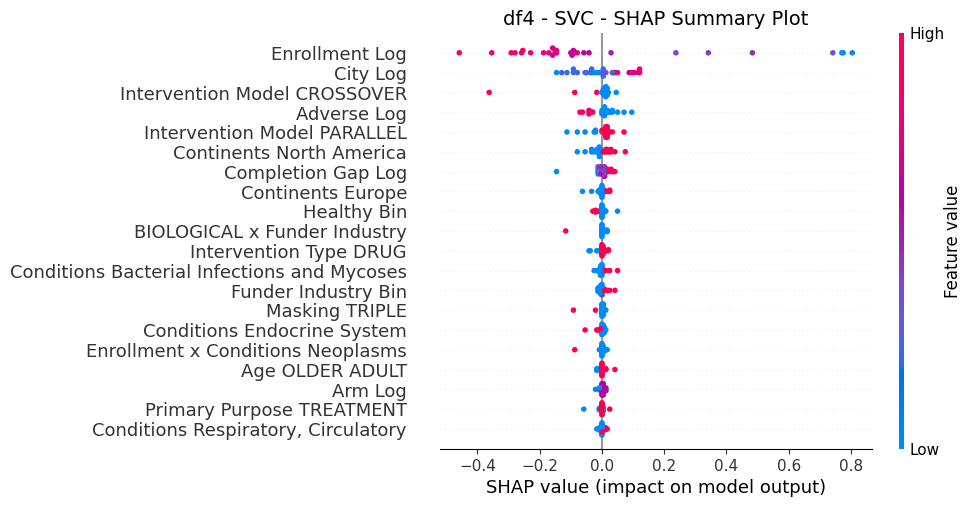

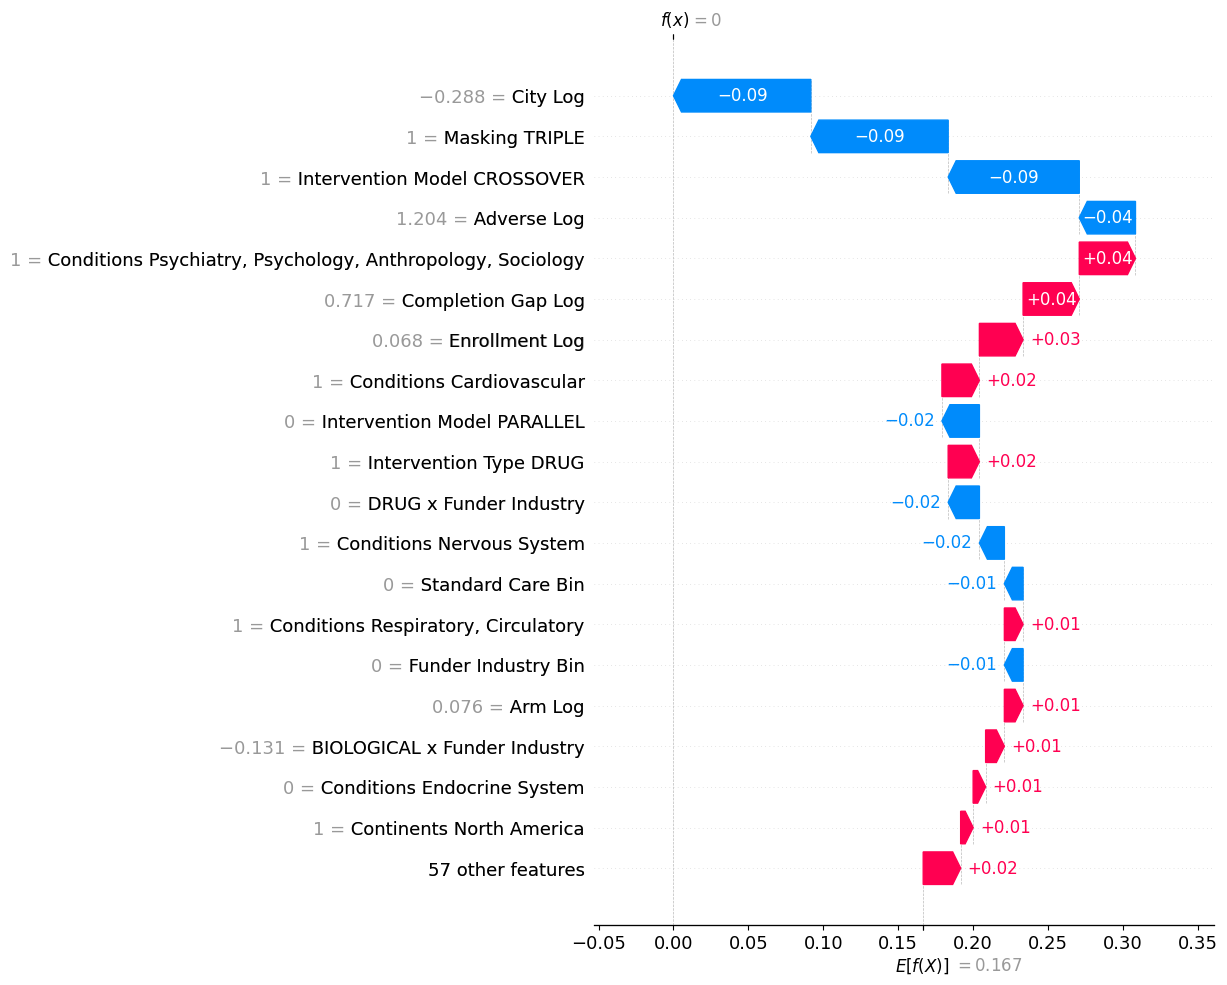

In [ ]:
# SHAP 
X_test_sam = shap.sample(X_test, 30)  # 30 cause computationaly too slow 
explainer = shap.Explainer(svc_model.best_estimator_.predict, X_test_sam)
shap_values = explainer(X_test_sam)

# Save plot
model = 'svc_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - SVC - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### Tree (Pruned)


In [ ]:
# cc_alphas values meaningful for dataset
tree = DecisionTreeClassifier(random_state = 42)
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
display(ccp_alphas.min(), ccp_alphas.mean(), ccp_alphas.max())

0.0

0.001349550885352544

0.19190718649049016

"Best Parameter criterion/max_depth: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}"

"Best Estimator : DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=4,\n                       min_samples_split=10, random_state=42)"

Model : Phase 4 - Decision Tree Classifier

a).
Accuracy Score : (True P + True N) / N total :
87.96%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2188
           1       0.64      0.73      0.68       462

    accuracy                           0.88      2650
   macro avg       0.79      0.82      0.80      2650
weighted avg       0.89      0.88      0.88      2650


c).
Matthews Correlation Coefficient (MCC) :
0.6058247369301248

d).
Plots :
ROC AUC : 0.88
PR AUC : 0.76


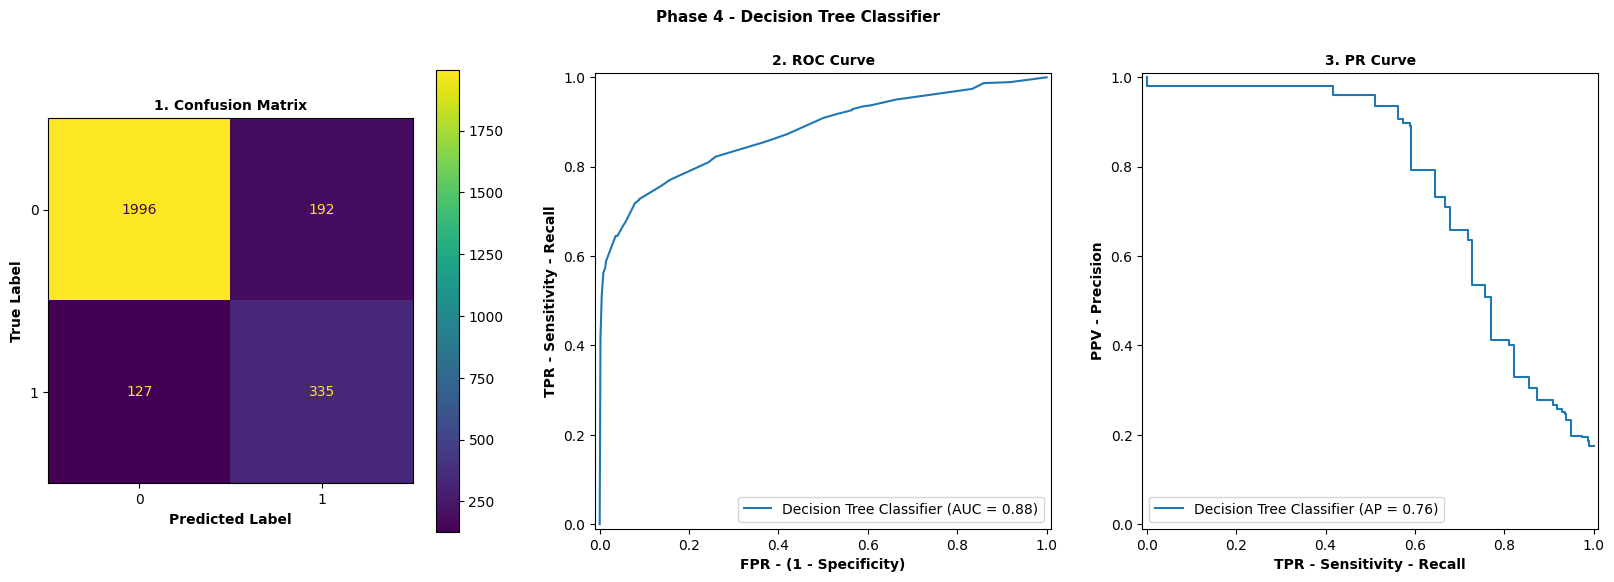

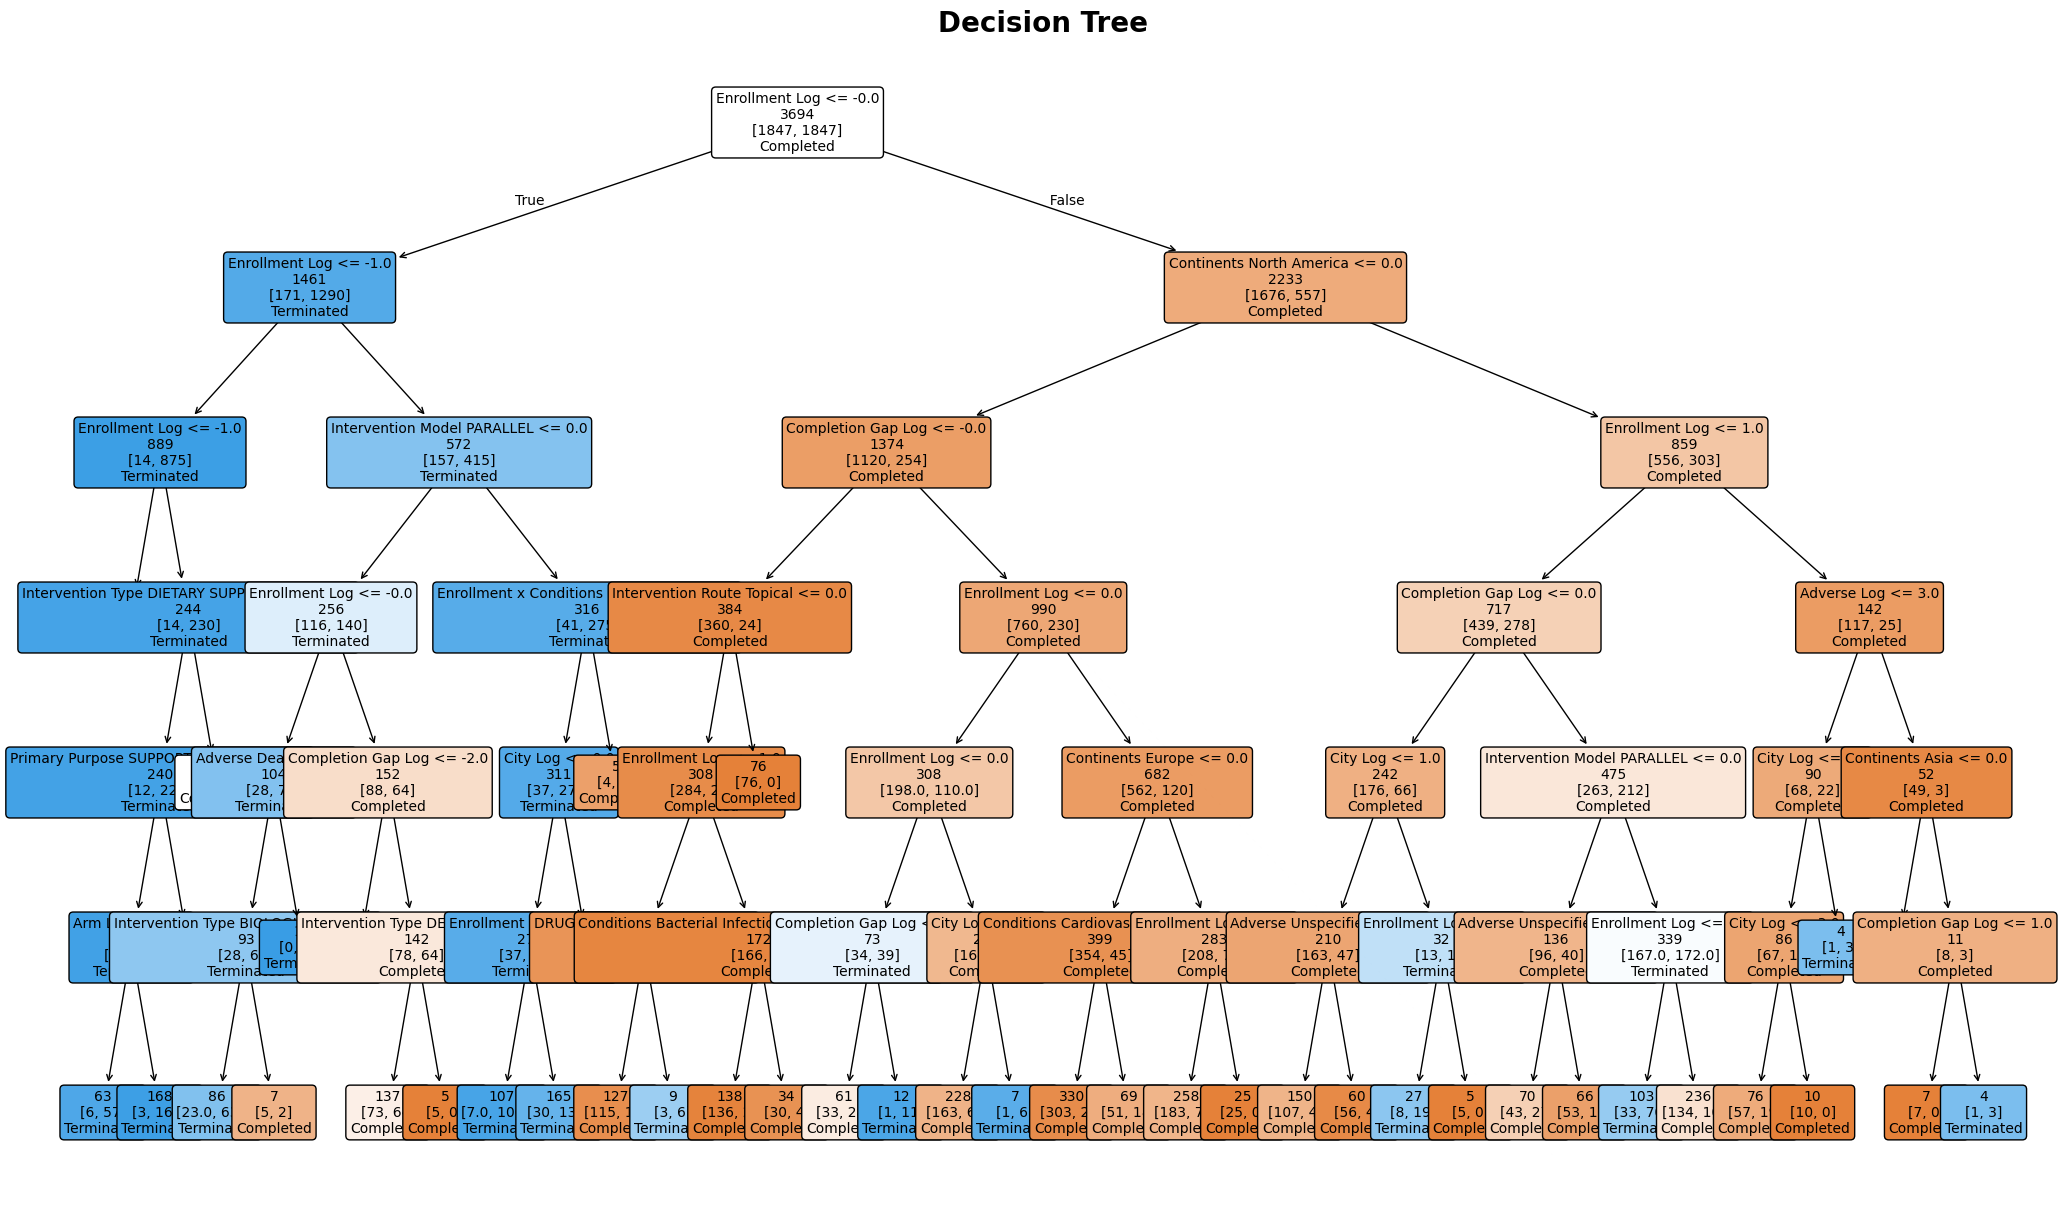

In [ ]:
# Model 
tree = DecisionTreeClassifier(random_state = 42)

# Hyperparameters CV
param_grid = {
    'criterion': ['gini', 'entropy'],           # Splitting strategy
    'max_depth': [2, 3, 4, 5, 6, 7, None],       # give small depth as choice # Pre-pruning --> Built in feature Selection
    'min_samples_split': [2, 5, 10],            # Min samples to split a node
    'min_samples_leaf': [1, 2, 4],              # Min samples in a leaf
    'max_features': [None, 'sqrt', 'log2'],     # Max features to consider at each split
    'ccp_alpha': np.linspace(0, np.max(ccp_alphas), 10),   # Post-Pruning --> Cost-complexity parameter
}

# CV
tree_grid = GridSearchCV(tree, param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
tr_model = tree_grid.fit(X_train, y_train)
display(f'Best Parameter criterion/max_depth: {tr_model.best_params_}')
display(f'Best Estimator : {tr_model.best_estimator_}')

# y_pred
y_pred_tr = tr_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, tr_model, X_test, y_test, y_pred_tr, "Decision Tree Classifier")

# Plot Tree
tree_clf = tr_model.best_estimator_

plt.figure(figsize = (25, 15))
plot_tree(
    tree_clf,
    feature_names = X_train.columns,
    class_names = ['Completed', 'Terminated'],
    max_depth = tr_model.best_params_['max_depth'],
    label = 'none',
    filled = True,
    rounded = True,
    proportion = False,
    impurity = False,
    precision = 0,
    fontsize = 10
)
plt.title("Decision Tree", fontsize = 20, fontweight = 'bold')
plt.show()


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_14040\2781199945.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)


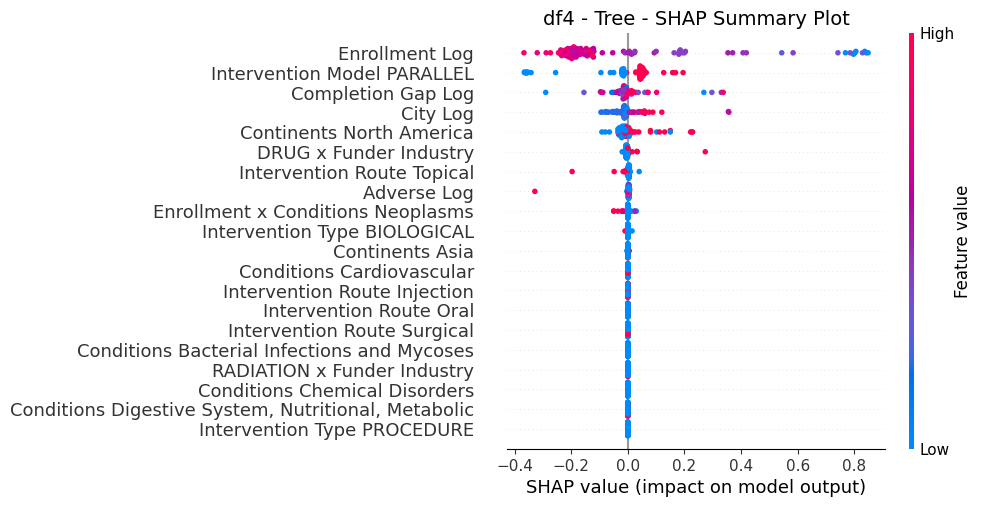

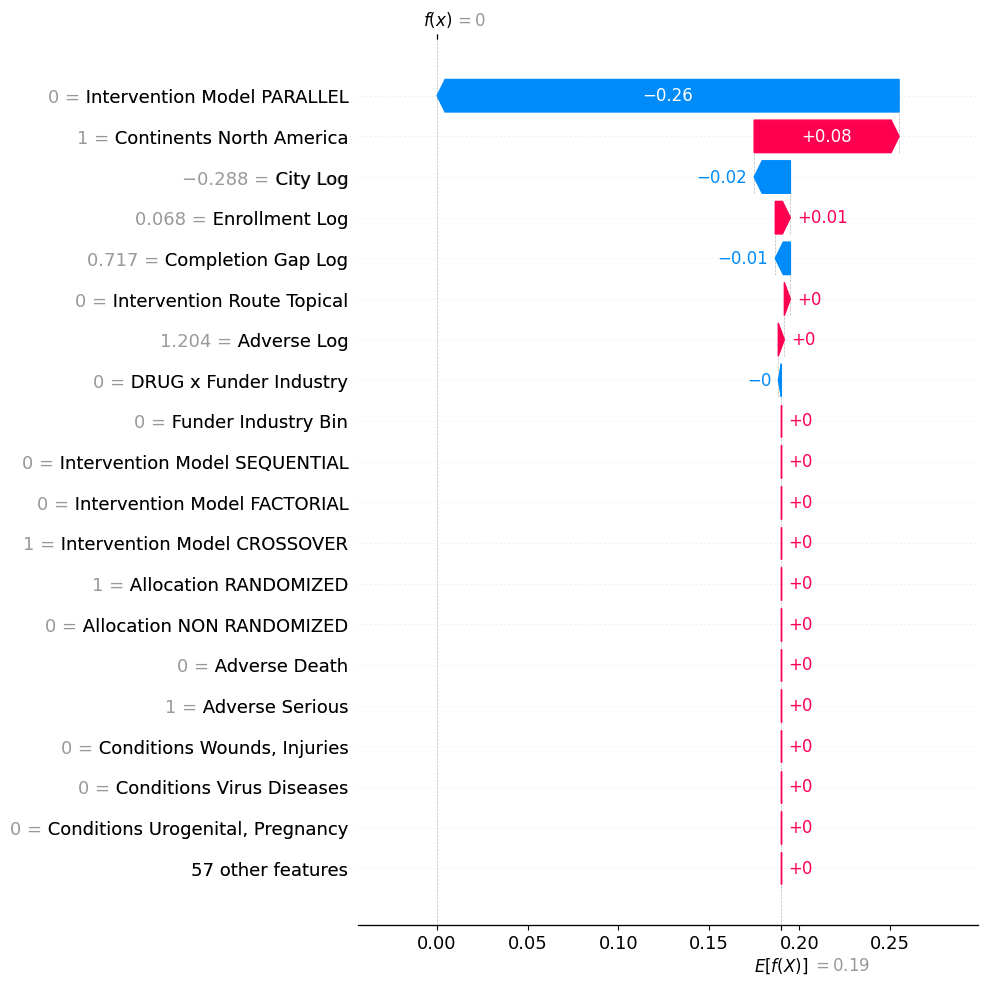

In [ ]:
# SHAP
X_test_sam = shap.sample(X_test, 100)
explainer = shap.Explainer(tr_model.best_estimator_.predict, X_test_sam)
shap_values = explainer(X_test_sam)

# Save plot
model = 'tr_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Tree - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### Random Forest

"Best Parameter criterion/bootstrap/n_estimators : {'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt'}"

'Best Estimator : RandomForestClassifier(random_state=42)'

Model : Phase 4 - Random Forest Classifier

a).
Accuracy Score : (True P + True N) / N total :
86.15%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      2188
           1       0.58      0.76      0.66       462

    accuracy                           0.86      2650
   macro avg       0.76      0.82      0.79      2650
weighted avg       0.88      0.86      0.87      2650


c).
Matthews Correlation Coefficient (MCC) :
0.5811670184008941

d).
Plots :
ROC AUC : 0.9
PR AUC : 0.77


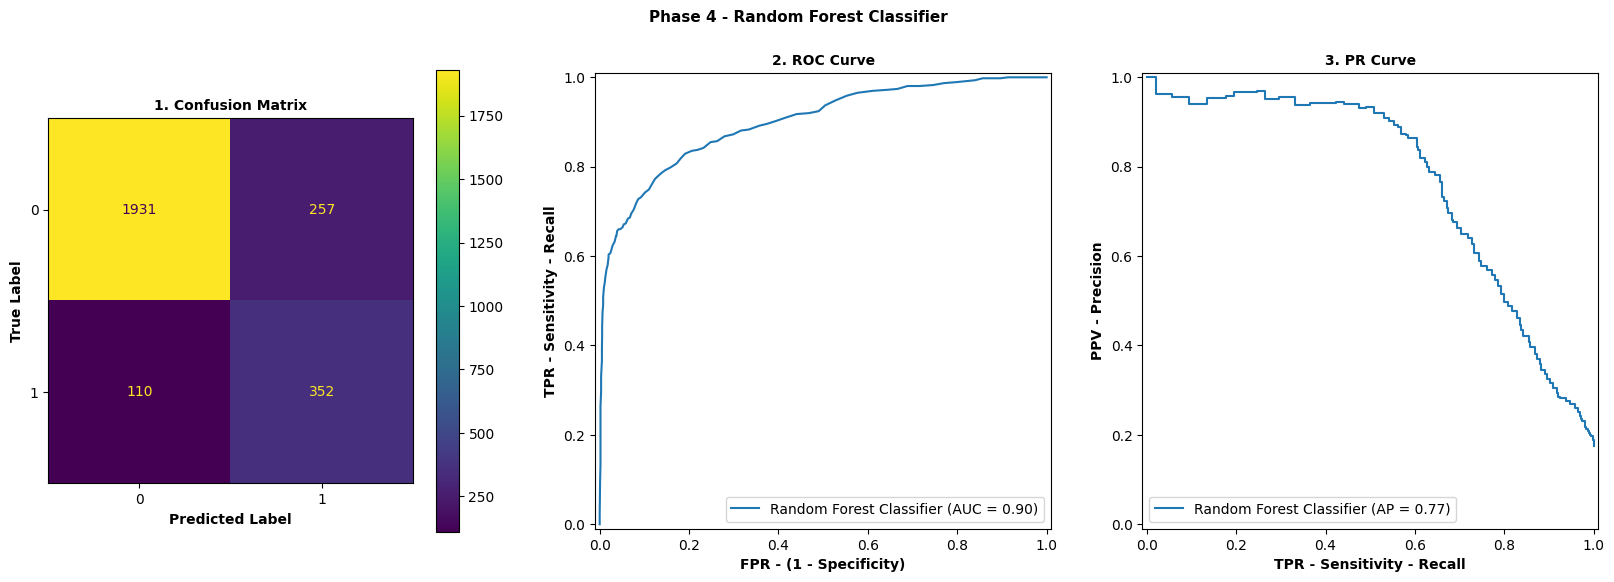

In [ ]:
# Model 
forest = RandomForestClassifier(random_state = 42)

# CV
param_grid = {
    "criterion" : ['gini', 'entropy', 'log_loss'], 
    "bootstrap" : [True, False],  # Bootstrap samples when building trees. If False, the whole dataset is used to build each tree.
    "max_features" : ["sqrt", "log2", None]  # None = m = p = Bagging Random Forest. / sqrt = m = sqrt(p) = Classic Random Forest. / log2 = m = log2(p) = Other Random Forest.
    } 

forest_grid = GridSearchCV(forest , param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
rf_model = forest_grid.fit(X_train, y_train)
display(f'Best Parameter criterion/bootstrap/n_estimators : {rf_model.best_params_}')
display(f'Best Estimator : {rf_model.best_estimator_}')

# y_pred
y_pred_rf = rf_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, rf_model, X_test, y_test, y_pred_rf, "Random Forest Classifier")


PermutationExplainer explainer: 101it [00:12,  1.73it/s]                         
C:\Users\Eugenia\AppData\Local\Temp\ipykernel_14040\3185747964.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)


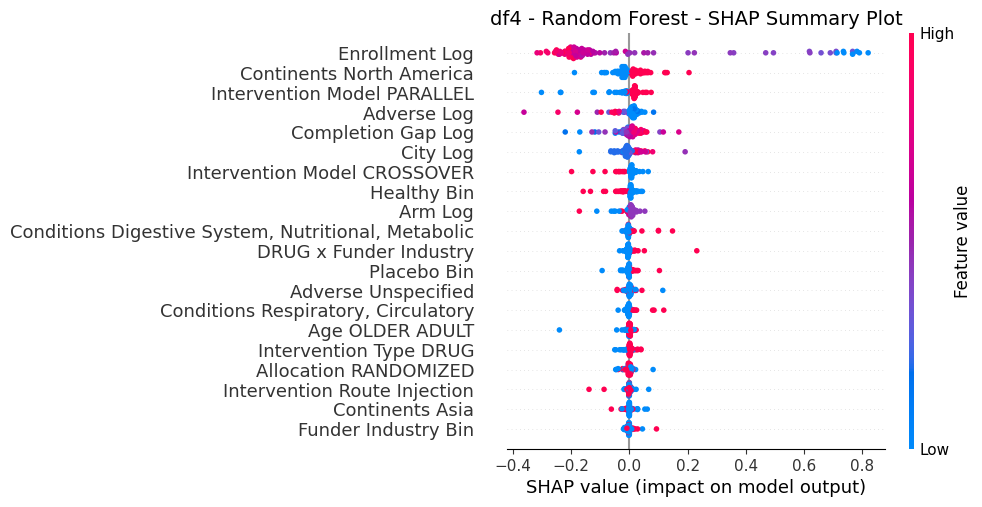

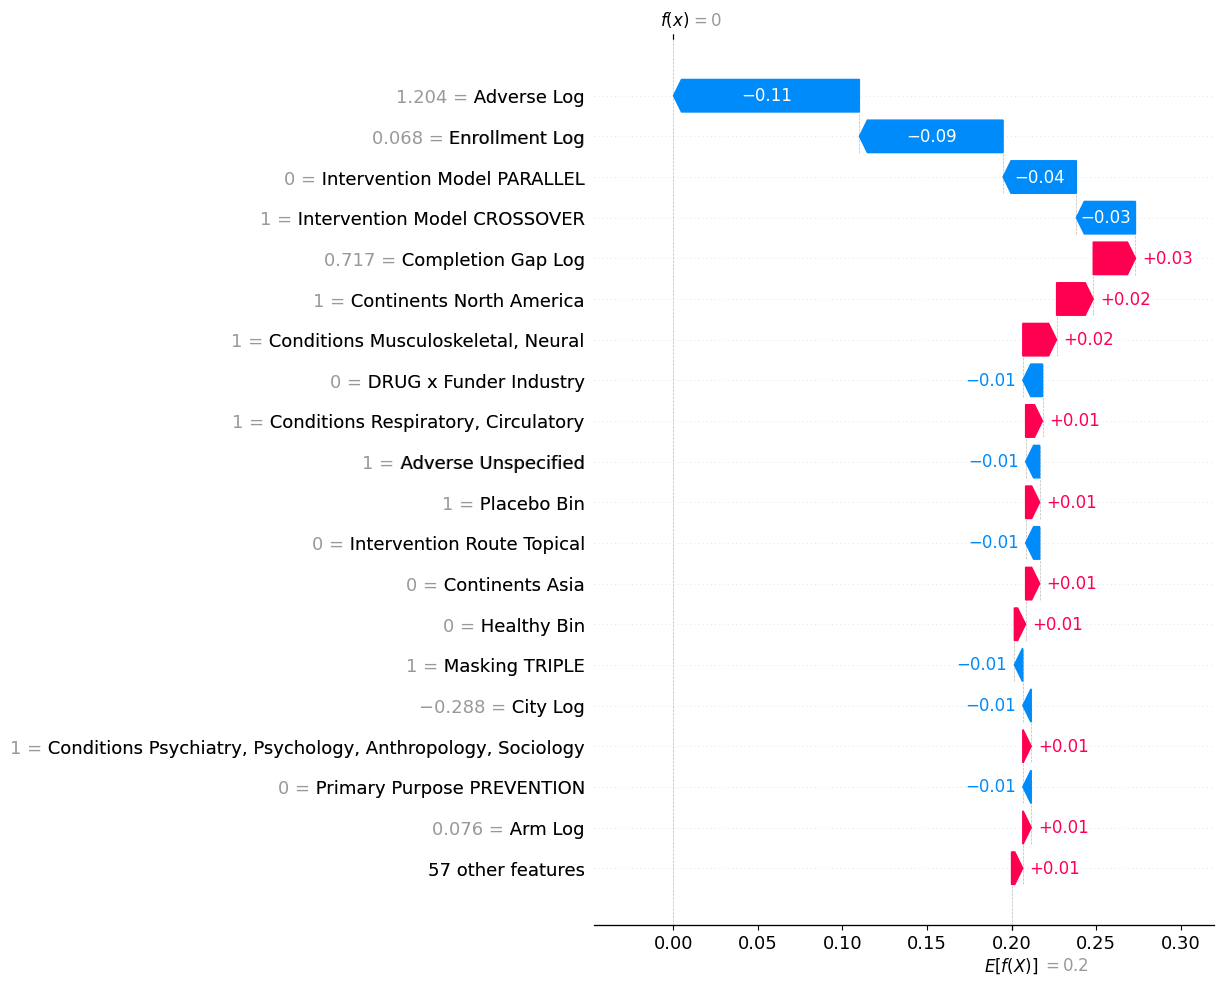

In [ ]:
# SHAP
X_test_sam = shap.sample(X_test, 100)
explainer = shap.Explainer(rf_model.best_estimator_.predict, X_test_sam)
shap_values = explainer(X_test_sam)

# Save plot
model = 'rf_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Random Forest - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### Gradient Boosting Classifier

"Best Parameter learning_rate : {'learning_rate': 0.13366666666666668, 'max_depth': 3}"

'Best Estimator : GradientBoostingClassifier(learning_rate=0.13366666666666668, random_state=42)'

Model : Phase 4 - Gradient Boosting Classifier

a).
Accuracy Score : (True P + True N) / N total :
85.92%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      2188
           1       0.57      0.77      0.65       462

    accuracy                           0.86      2650
   macro avg       0.76      0.82      0.78      2650
weighted avg       0.88      0.86      0.87      2650


c).
Matthews Correlation Coefficient (MCC) :
0.5784740999044496

d).
Plots :
ROC AUC : 0.91
PR AUC : 0.81


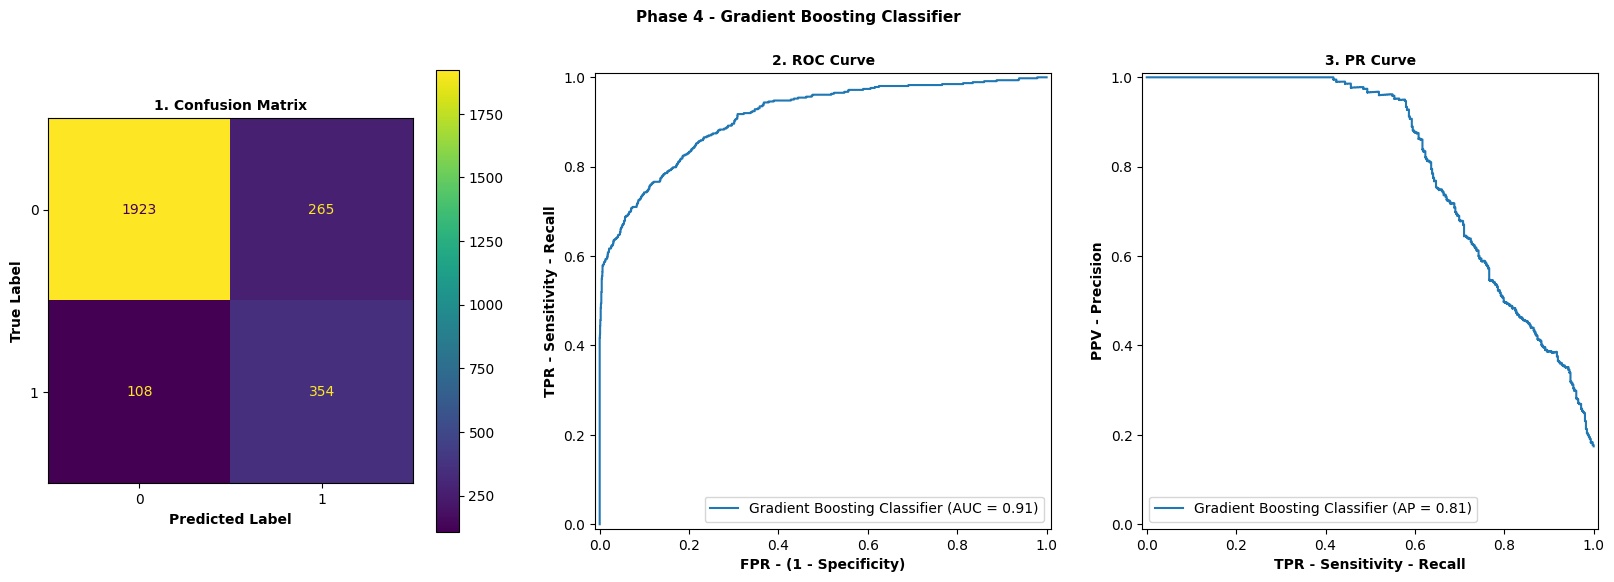

In [ ]:
# Model (+10 mins)
gra_boost = GradientBoostingClassifier(random_state = 42)  

# CV
param_grid = {
    "learning_rate" : np.linspace(0.001, 0.2, 10, endpoint = True),  # Typical values are 0.01 or 0.001
    'max_depth' : list(range(1, 11)),  # Typical values are between 3 and 10
    # 'n_estimators' : list(range(100, 1101, 100)) # Number of boosting trees. Default = 100.
    }

gra_boost_grid = GridSearchCV(gra_boost , param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
gb_model = gra_boost_grid.fit(X_train, y_train)
display(f'Best Parameter learning_rate : {gb_model.best_params_}')
display(f'Best Estimator : {gb_model.best_estimator_}')

# y_pred
y_pred_gb = gb_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, gb_model, X_test, y_test, y_pred_gb, "Gradient Boosting Classifier")

# Feature Importance


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_14040\284619891.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)


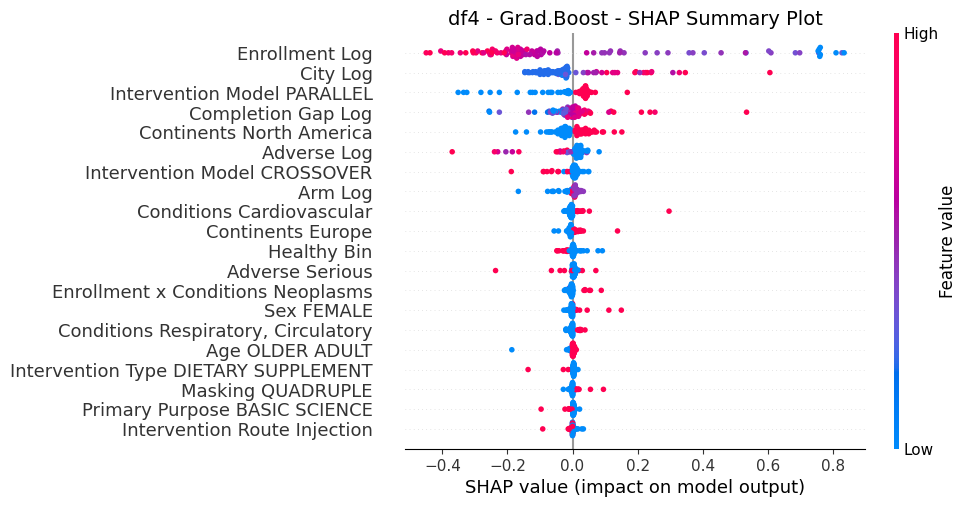

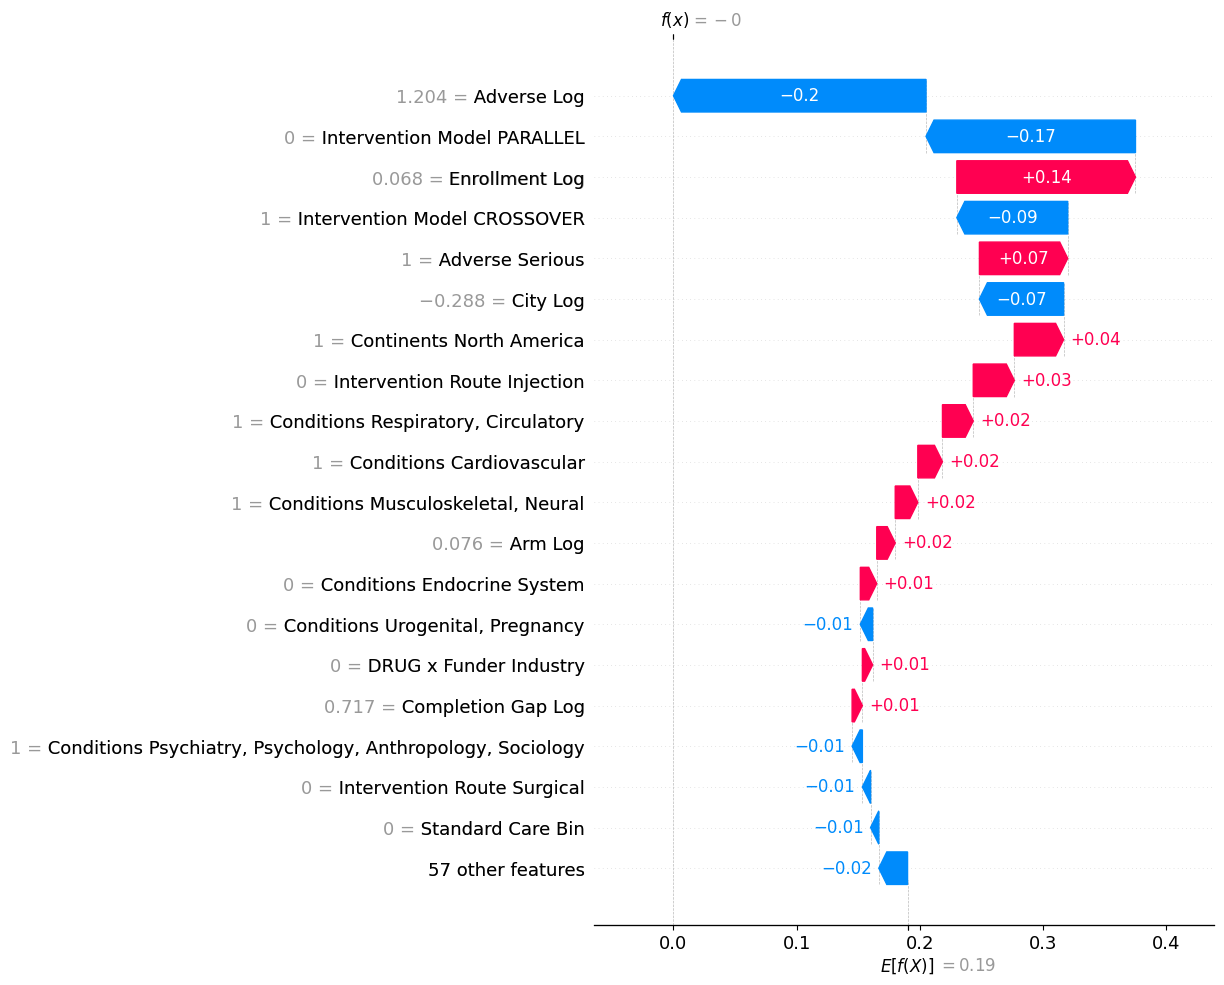

In [ ]:
# SHAP
X_test_sam = shap.sample(X_test, 100)
explainer = shap.Explainer(gb_model.best_estimator_.predict, X_test_sam)
shap_values = explainer(X_test_sam)

# Save plot
model = 'gb_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Grad.Boost - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### Extreme Gradient Boost

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Model : Phase 4 - Gradient Boosting Classifier

a).
Accuracy Score : (True P + True N) / N total :
87.06%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2188
           1       0.60      0.77      0.67       462

    accuracy                           0.87      2650
   macro avg       0.77      0.83      0.80      2650
weighted avg       0.89      0.87      0.88      2650


c).
Matthews Correlation Coefficient (MCC) :
0.6012030863587542

d).
Plots :
ROC AUC : 0.91
PR AUC : 0.81


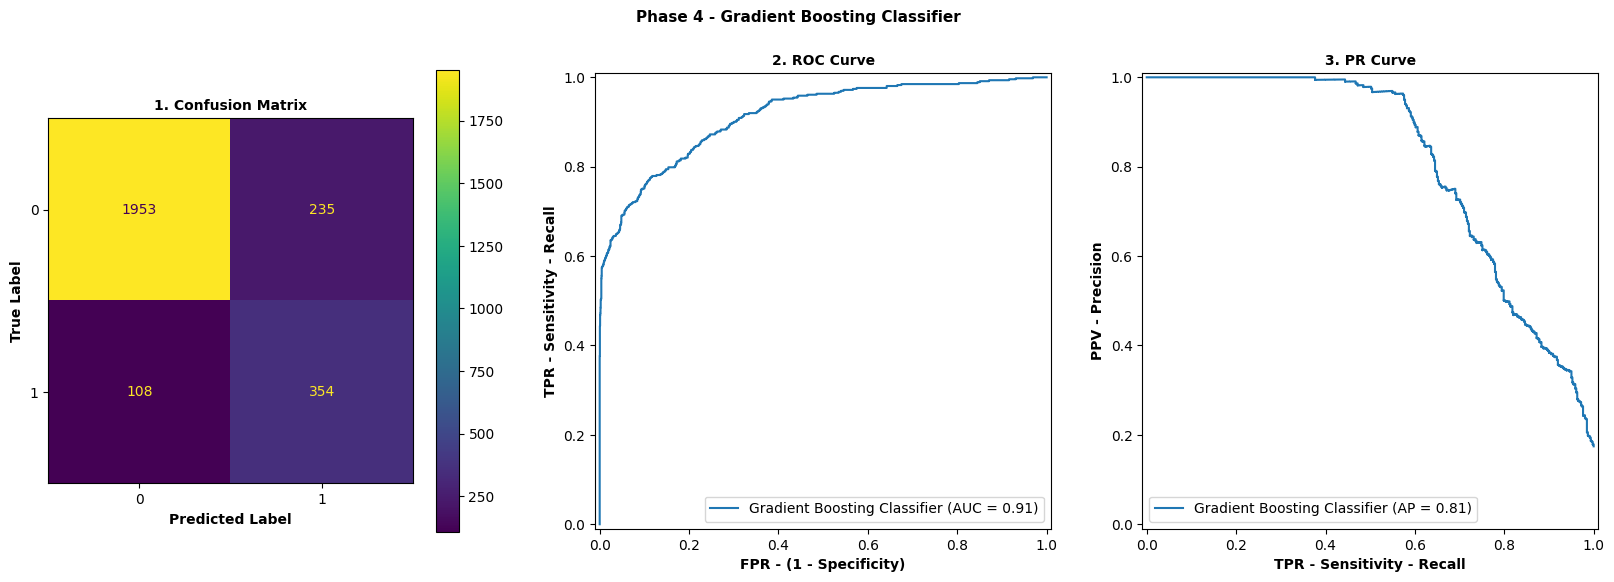

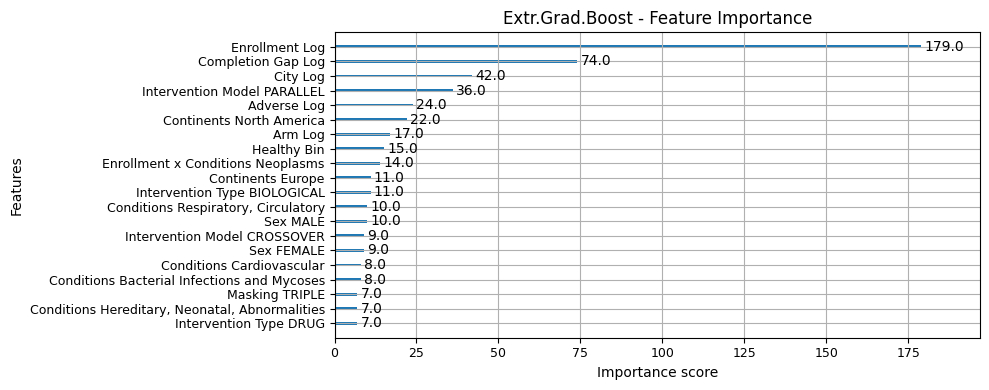

In [ ]:
# Model
xgb = XGBClassifier(
    objective='binary:logistic', eval_metric = 'logloss', random_state = 42) # Doc: For classification, ‘log_loss’ is the only option.

# CV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]}

xgb_grid = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1, verbose = 1)

# Final Model
xgb_model = xgb_grid.fit(X_train, y_train)
print("Best Parameters:", xgb_model.best_params_)
# print("Best Estimator:", xgb_model.best_estimator_) # too long output. 

# y_pred
y_pred_xgb = xgb_model.predict(X_test)

# Accuracy Score
accuracy(dfi, i, xgb_model, X_test, y_test, y_pred_xgb, "Gradient Boosting Classifier")

# Plot Feature Importances
fig, ax = plt.subplots(figsize = (10, 4), squeeze = True)
plot_importance(xgb_model.best_estimator_ , max_num_features = 20, ax = ax)
plt.yticks(fontsize = 9)
plt.xticks(fontsize = 9)
plt.title("Extr.Grad.Boost - Feature Importance")
plt.tight_layout()
plt.show()


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_14040\2929307477.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)


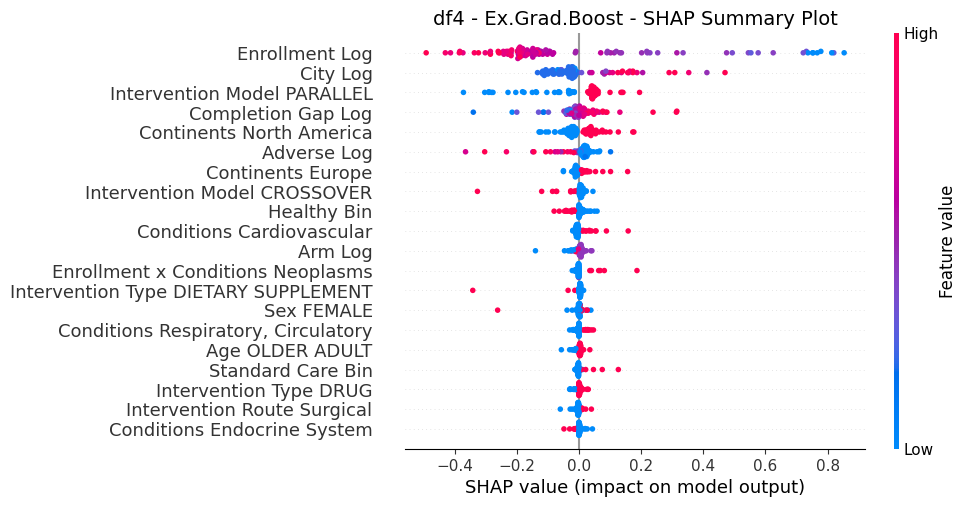

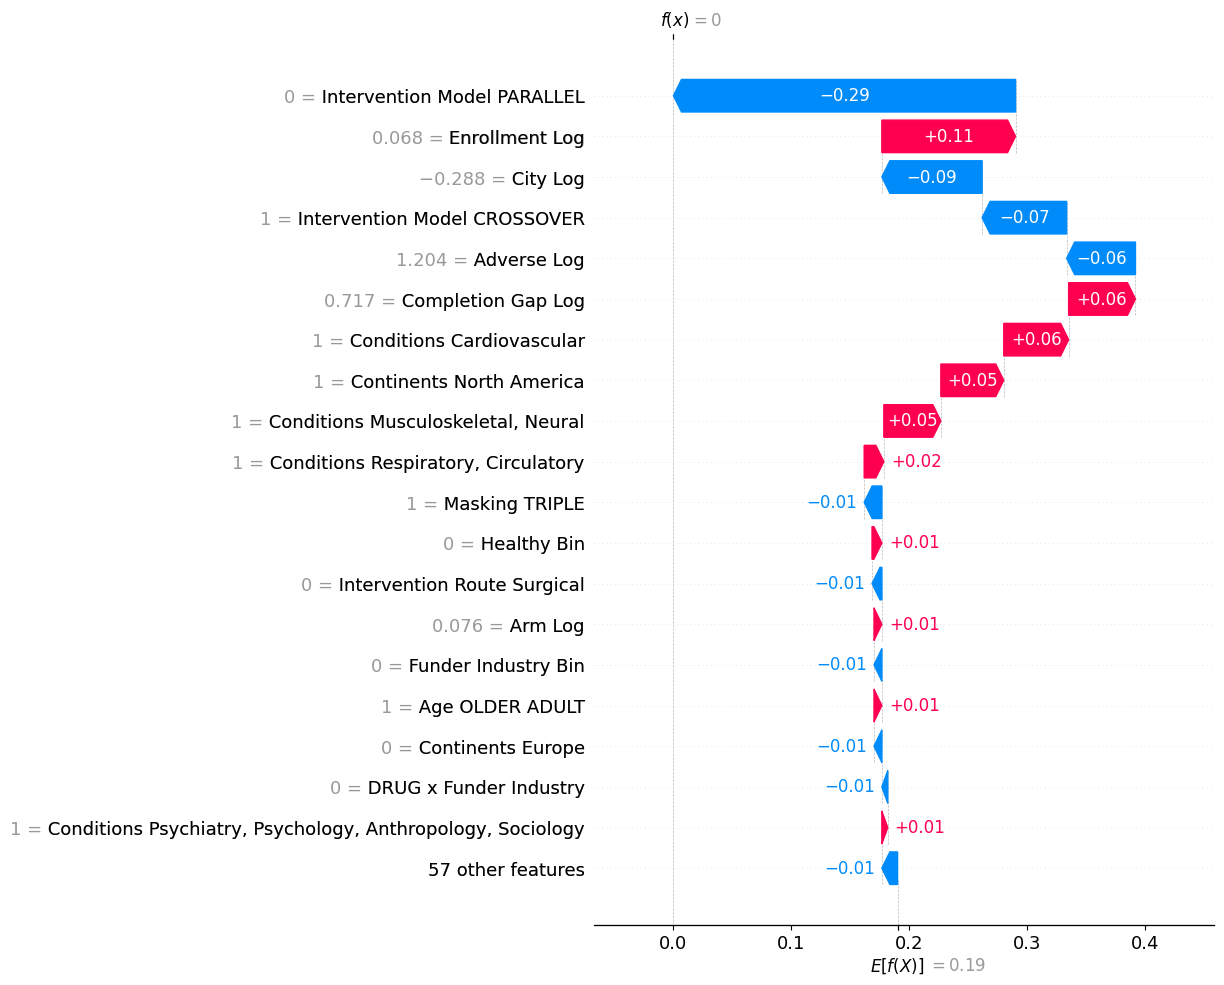

In [ ]:
# SHAP
X_test_sam = shap.sample(X_test, 100)
explainer = shap.Explainer(xgb_model.best_estimator_.predict, X_test_sam)
shap_values = explainer(X_test_sam)

# Save plot
model = 'xgb_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Ex.Grad.Boost - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

# ROC Curve

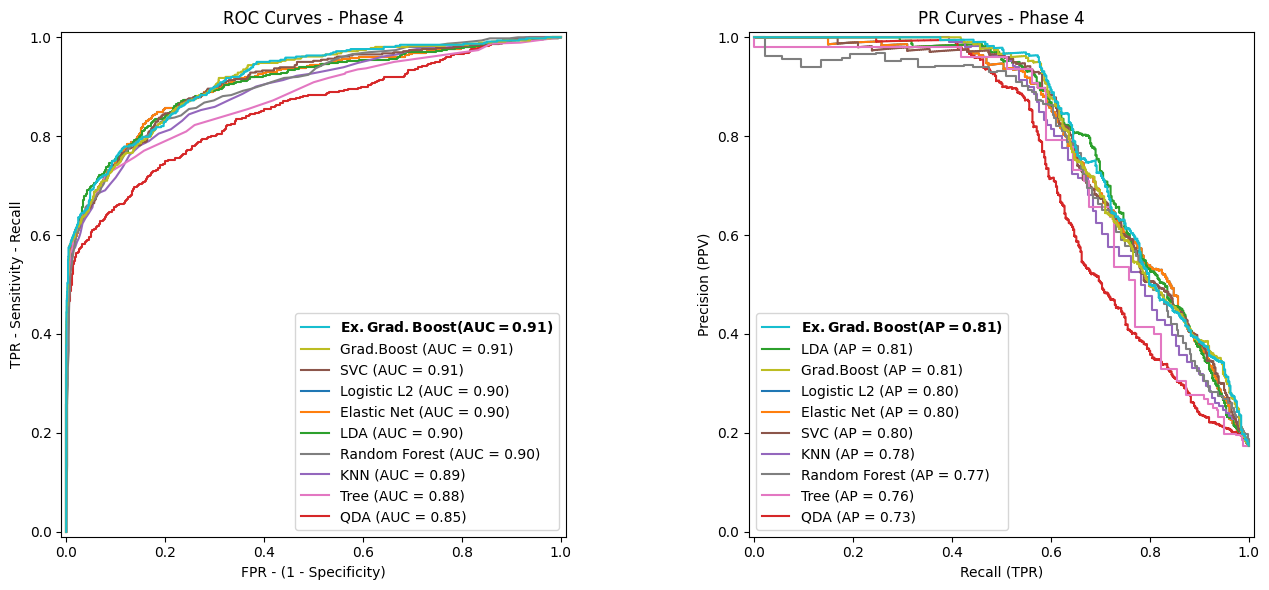

In [ ]:
# Save Path
folder_roc = "roc_plots"
os.makedirs(folder_roc, exist_ok=True)
filename = f"roc_df{i}.png"
filepath = os.path.join(folder_roc, filename)

# Models
models = [
    ("Logistic L2", log_model, X_test, y_test),
    ("Elastic Net", el_model, X_test, y_test),
    ("LDA", lda_model, X_test, y_test),
    ("QDA", qda_model, X_test, y_test),
    ("KNN", knn_model, X_test, y_test),
    ("SVC", svc_model, X_test, y_test),
    ("Tree", tr_model, X_test, y_test),
    ("Random Forest", rf_model, X_test, y_test),
    ("Grad.Boost", gb_model, X_test, y_test),
    ("Ex.Grad.Boost", xgb_model, X_test, y_test)
]

fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(14, 6))

roc_aucs = []
pr_aucs = []

for original_name, model, X_test_model, y_test_model in models:
    y_score = model.predict_proba(X_test_model)[:, 1]  

# ROC Curve
    auc = roc_auc_score(y_test_model, y_score)
    label_roc = f"{original_name} (AUC = {auc:.2f})"
    roc = RocCurveDisplay.from_estimator(
        model, X_test_model, y_test_model, ax=ax_roc,
        name=label_roc, pos_label = 1  # Completed = 0, Terminated = 1
    )
    roc_aucs.append((auc, label_roc, roc.line_))

# PR Curve
    ap = average_precision_score(y_test_model, y_score)
    label_pr = f"{original_name} (AP = {ap:.2f})"
    pr = PrecisionRecallDisplay.from_estimator(
        model, X_test_model, y_test_model, ax=ax_pr,
        name=label_pr, pos_label=1
    )
    pr_aucs.append((ap, label_pr, pr.line_))

# Sort models at legends
roc_aucs.sort(key=lambda x: x[0], reverse=True)
pr_aucs.sort(key=lambda x: x[0], reverse=True)

# Bold best model
roc_handles = [item[2] for item in roc_aucs]
roc_labels = [f"$\\bf{{{item[1]}}}$" if i == 0 else item[1] for i, item in enumerate(roc_aucs)]
ax_roc.legend(roc_handles, roc_labels, loc="lower right")

pr_handles = [item[2] for item in pr_aucs]
pr_labels = [f"$\\bf{{{item[1]}}}$" if i == 0 else item[1] for i, item in enumerate(pr_aucs)]
ax_pr.legend(pr_handles, pr_labels, loc="lower left")

# withut bold
# ax_roc.legend([item[2] for item in roc_aucs], [item[1] for item in roc_aucs], loc = "lower right")
# ax_pr.legend([item[2] for item in pr_aucs], [item[1] for item in pr_aucs], loc = "lower left")

# Titles/ labels
ax_roc.set_title(f"ROC Curves - Phase {i}")
ax_roc.set_ylabel("TPR - Sensitivity - Recall", fontsize=10)
ax_roc.set_xlabel("FPR - (1 - Specificity)", fontsize=10)

ax_pr.set_title(f"PR Curves - Phase {i}")
ax_pr.set_ylabel("Precision (PPV)", fontsize=10)
ax_pr.set_xlabel("Recall (TPR)", fontsize=10)

plt.tight_layout()

# Save Plot
plt.savefig(filepath, dpi=100, bbox_inches="tight")
plt.show()
plt.close()

# Results

In [ ]:
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"Execution time: {elapsed_minutes:.2f} minutes")

Execution time: 7.97 minutes
